In [1]:
import sys
import os
sys.path.append(os.path.abspath('../..'))
import datetime
import concurrent.futures
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import threading

In [2]:
from utlis.sync_utlis.sync_df_utlis import find_calib_file
from utlis.scan_engine_utlis.scan_engine_utlis import (
    read_failed_paths,
    match_date_pattern,
    assign_status_codes,
)
# from scan_engine.status_fields_config_24summ import STATUS_FIELDS_CONFIG
from status_fields_config_oct3v1_ssh_updated20250305 import STATUS_FIELDS_CONFIG
# Import functions from utils.py
from utlis.scan_engine_utlis.scan_log_utlis import (
    load_scan_log,
    save_scan_log,
    clean_scan_log,
    update_scan_log,
    get_folders_to_scan
)

def scan_folder(folder_name, base_folder, failed_paths, config, rec_files_to_scan):
    folder_path = os.path.join(base_folder, folder_name)
    rec_files_data = []  # To store rec files and their status
    calib_files = []  # To store calibration files

    # Check for calibration files starting with 'calib'
    for file_name in os.listdir(folder_path):
        if file_name.startswith("calib"):
            calib_files.append(file_name)

    # Traverse subfolders within this folder
    for subfolder_name in rec_files_to_scan:
        subfolder_path = os.path.join(folder_path, subfolder_name)

        # Check for subfolders starting with a digit (rec folders)
        if os.path.isdir(subfolder_path) and subfolder_name[0].isdigit():
            # Find calibration file for each subfolder
            calib_file = find_calib_file(subfolder_path)

            # Assign status codes dynamically based on the config
            rec_file_data = assign_status_codes(
                folder_name, subfolder_path, calib_file, failed_paths, config
            )

            rec_file_data['rec_file'] = subfolder_name  # Add rec_file to the data
            # Add date-time for update and some future
            rec_file_data['scan_time'] = datetime.datetime.now().isoformat()

            rec_files_data.append(rec_file_data)

    return {
        'date_folder': folder_name,
        'calib_files': calib_files,  # Store the calibration files under date_folder level
        'rec_files_data': rec_files_data  # Each rec file with its status fields
    }

def log_folder_to_parquet_sep(base_folder, failed_paths_file, config, force_rescan_rec_files=None, rescan_threshold_days=7):
    """Log folders and save Parquet in subfolders with partial scan support."""

    # Paths for scan log
    scan_log_path = os.path.join(base_folder, 'paret', 'scan_log.csv')

    # Load or initialize the scan log
    scan_log_df = load_scan_log(scan_log_path)

    # Read manually inputted failed paths
    failed_paths = read_failed_paths(failed_paths_file) if failed_paths_file else set()

    # Forced rescans
    # force_rescan_rec_files = [
    #     # ('2023-10-01', '001'),
    #     # ('2023-10-02', '002'),
    #     # Add more as needed
    # ]
    # force_rescan_rec_files_set = set(force_rescan_rec_files)
    
    if force_rescan_rec_files is None:
        force_rescan_rec_files = []
    force_rescan_rec_files_set = set(force_rescan_rec_files)



    # Rescan threshold
    # rescan_threshold_days = 7

    # Determine folders to scan
    folders_to_scan = get_folders_to_scan(base_folder, scan_log_df, rescan_threshold_days, force_rescan_rec_files_set)

    if not folders_to_scan:
        print("No new or modified folders to scan.")
        return

    # Use ThreadPoolExecutor for parallel folder scanning
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = []
        for date_folder, rec_files_to_scan in folders_to_scan.items():
            futures.append(
                executor.submit(
                    scan_folder,
                    date_folder,
                    base_folder,
                    failed_paths,
                    config,
                    rec_files_to_scan
                )
            )

        for future in concurrent.futures.as_completed(futures):
            folder_log = future.result()
            date_folder = folder_log['date_folder']
            calib_files = folder_log.get('calib_files', [])

            # Ensure 'calib_files' is always a list of strings
            calib_files = [str(f) for f in calib_files] if calib_files else []

            # Process and save each experiment's log separately
            for rec_file_data in folder_log['rec_files_data']:
                rec_file = rec_file_data['rec_file']
                subfolder_save_path = os.path.join(base_folder, date_folder, rec_file, "folder_log.parquet")

                # Ensure the experiment/rec_file folder exists
                os.makedirs(os.path.dirname(subfolder_save_path), exist_ok=True)

                # Add 'date_folder' and 'calib_files' to rec_file_data
                rec_file_data['date_folder'] = date_folder
                rec_file_data['calib_files'] = calib_files

                # Dynamically ensure all relevant columns are strings based on config
                status_columns = list(config.keys())
                df = pd.DataFrame([rec_file_data])
                df[status_columns] = df[status_columns].astype(str)

                # Convert the data into a DataFrame and save the Parquet file
                table = pa.Table.from_pandas(df)
                pq.write_table(table, subfolder_save_path)

                print(f"Log for {rec_file} saved at {subfolder_save_path}")

                # Update the scan log
                scan_log_df = update_scan_log(scan_log_df, date_folder, rec_file)

    # Clean up the scan log
    scan_log_df = clean_scan_log(scan_log_df, base_folder)

    # Save the updated scan log
    save_scan_log(scan_log_df, scan_log_path)

if __name__ == "__main__":
    base_folder = "/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1" #"/hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ"  # Replace with your base folder
    # save_path = os.path.join(base_folder, 'paret')
    failed_paths_file = '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/sync_failed_brws.txt'  # File containing failed paths


    force_rescan_rec_files = [
        # ('2023-10-01', '001'),
        # ('2023-10-02', '002'),
        # Add more as needed
    ]
    rescan_threshold_days = 0.0001 # 7 days, but guess if i mess up i can just change it to automatically rescan all, smile... #0.1

    log_folder_to_parquet_sep(base_folder, failed_paths_file, STATUS_FIELDS_CONFIG,
                              force_rescan_rec_files=force_rescan_rec_files,
                              rescan_threshold_days=rescan_threshold_days)


Log for 20241224PMCLE1mini_p20240303PMC2_14_44 saved at /hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2025_03_11/20241224PMCLE1mini_p20240303PMC2_14_44/folder_log.parquet
Log for 20241224PMCLE1_14_12 saved at /hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2025_03_11/20241224PMCLE1_14_12/folder_log.parquet
Log for 20241224PMCLE1mini_p20240303PMC1_14_21 saved at /hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2025_03_11/20241224PMCLE1mini_p20240303PMC1_14_21/folder_log.parquet
Log for 2social_mini_0605pmc_single_15_38 saved at /hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_10_30/2social_mini_0605pmc_single_15_38/folder_log.parquet
Log for 2social_mini_0605pmc_single_15_18 saved at /hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_10_30/2social_mini_0605pmc_single_15_18/folder_log.parquet
Log for 2social_mini_0605pmc_single_15_00 saved at /hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_10_30/2social_mini_0605pmc_single_15_00/folder_log.parquet
Log for 2social_mini_2024081

In [3]:
# sys.path.append(os.path.abspath('../..'))
from utlis.scan_engine_utlis.scan_engine_utlis import read_all_parquet_files
# base_folder = "/hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ"
all_df = read_all_parquet_files(base_folder)

In [7]:
import pyarrow.compute as pc
table = all_df #combined_df
# Filter mir_generate_param == 0 and sync != 3
filter_mask = pc.and_(
    # pc.equal(table['sync'], '1'),
    # pc.not_equal(table['com'], '1')
    pc.equal(table['sync'], '1'),
    pc.and_(
                pc.equal(table['com'], '0'),
                pc.not_equal(table['social'], '1')
            ),
)

# Apply the filter and print the results
for_com = table.filter(filter_mask)

# Print each row of the filtered table
print(for_com.to_pandas())  # This will display the filtered data in a familiar pandas-like format


Empty DataFrame
Columns: [mir_generate_param, sync, dropf_handle, com, com_vis, social, miniscope, test, after_oxytocin, before_oxytocin, dannce, dannce_vis, mini_rec_sync, rec_file, scan_time, date_folder, calib_files]
Index: []


In [ ]:
# # Function to create the full expdir path and run the command
# def run_command(base_path, date_folder, rec_file):
#     expdir_path = os.path.join(base_path, date_folder, rec_file)
#     command = f"python slurm_launch_predict.py --expdir {expdir_path} --predict_com"
#     print(f"Executing command: {command}")
#     os.system(command)

pyarrow.Table
mir_generate_param: string
sync: string
dropf_handle: string
com: string
rec_file: string
scan_time: string
date_folder: string
calib_files: list<element: string>
  child 0, element: string
----
mir_generate_param: [["1"],["1"],...,["1"],["1"]]
sync: [["1"],["1"],...,["1"],["1"]]
dropf_handle: [["0"],["0"],...,["0"],["0"]]
com: [["0"],["0"],...,["0"],["0"]]
rec_file: [["1686940_no_holes"],["1686940_left_right_2"],...,["24Anshu_f_paint_2mice"],["24Anshu_f_paint_2mice_2"]]
scan_time: [["2024-11-05T14:07:26.137916"],["2024-11-05T14:07:26.127355"],...,["2024-11-05T14:07:26.068943"],["2024-11-05T14:07:26.119025"]]
date_folder: [["2024_06_26"],["2024_06_27"],...,["2024_10_03_micecolor_test"],["2024_10_03_micecolor_test"]]
calib_files: [[["calib_before","calib_stop2","calib_stop3","calib_before2"]],[["calib_after_6","calib_after_3","calib_after_7","calib_before3","calib_before_6","calib_before_4","calib_before_7","calib_after_4","calib_after_5","calib_before_5"]],...,[["calib_19

In [6]:
from concurrent.futures import ThreadPoolExecutor
import os

# for_com = filtered_table
slurm_launch_file = '/hpc/group/tdunn/lq53/tianqing_pytorch_dannce/dannce_/slurm_launch_predict.py'

def check_expdir(expdir):
    if not os.path.exists(expdir):
        print(f"Skipping: Experiment directory {expdir} does not exist")
        return None  # Return None or skip processing this directory
    return expdir


# Function to create the full expdir path and print the command for dry-run
def run_command(base_path, date_folder, rec_file, dry_run=True):
    expdir_path = os.path.join(base_path, date_folder, rec_file)
    
    # Check if the experiment directory exists before running the command
    if check_expdir(expdir_path) is None:
        return  # Skip this execution if the directory does not exist
    
    # command = f"python {slurm_launch_file} --expdir {expdir_path} --predict_com"
    command = f"conda run -n sdannce python {slurm_launch_file} --expdir {expdir_path} --predict_com" # --allow_overwrite remove allow_overwrite by default.

    if dry_run:
        print(f"[DRY-RUN] Command: {command}")
    else:
        print(f"Executing command: {command}")
        os.system(command)


# Extract relevant data from the filtered PyArrow Table `for_com`
base_path = base_folder
# base_path = "/hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ"  # Adjust this base path as needed
records = [
    {
        'date_folder': date_folder.as_py(),  # Convert to string using as_py()
        'rec_file': rec_file.as_py()         # Convert to string using as_py()
    }
    for date_folder, rec_file in zip(for_com['date_folder'], for_com['rec_file'])
]

# Run in parallel with dry-run enabled for testing
max_concurrent_jobs = 4 # chosing how mnay gpu to take, let's say maybe 4??? or 5... we're not urgent so...

dry_run = False #True  # Set to False to execute commands
# parallelly submission of jobs is just stupid....
with ThreadPoolExecutor() as executor: #
    futures = [
        executor.submit(run_command, base_path, record['date_folder'], record['rec_file'], dry_run)
        for record in records
    ]

# print("Dry-run test complete. Review the printed commands.")


Executing command: conda run -n sdannce python /hpc/group/tdunn/lq53/tianqing_pytorch_dannce/dannce_/slurm_launch_predict.py --expdir /hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_12_31/20241212v1l1r2mini_12_04 --predict_comExecuting command: conda run -n sdannce python /hpc/group/tdunn/lq53/tianqing_pytorch_dannce/dannce_/slurm_launch_predict.py --expdir /hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_10_25/2male_mice_test --predict_com
Executing command: conda run -n sdannce python /hpc/group/tdunn/lq53/tianqing_pytorch_dannce/dannce_/slurm_launch_predict.py --expdir /hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_10_25/2male_mice_test_miniscope --predict_com
Executing command: conda run -n sdannce python /hpc/group/tdunn/lq53/tianqing_pytorch_dannce/dannce_/slurm_launch_predict.py --expdir /hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2025_02_12/20241001PMCRE2mini_13_57 --predict_com
Executing command: conda run -n sdannce python /hpc/group/tdunn/lq53/tianqing_pyt

In [8]:
import pyarrow.compute as pc
table = all_df  # combined_df

# Filter dropf_handle == 1, com != 1, and social != 1
# filter_mask = pc.and_(
#     # pc.equal(table['dropf_handle'], '1'),
#     pc.not_equal(table['com'], '1'),
#     pc.not_equal(table['social'], '1')
# )

# filter_mask = pc.and_(
#     # pc.and_(
#         # pc.not_equal(table['date_folder'], '2024_11_06'),
        
#         # pc.and_(
#         #     pc.not_equal(table['date_folder'], '2024_11_06'),
#         #     # pc.and_(
#         #     #     pc.not_equal(table['date_folder'], '2024_11_06'),
#         #     #     pc.not_equal(table['date_folder'], '2024_09_18')
#         #     # ),
#         #     pc.not_equal(table['date_folder'], '2024_11_07')
#         # ),
#     pc.equal(table['com'], '1'),
#     # ),
#     pc.not_equal(table['social'], '1')
#     # pc.and_(
#     #     pc.not_equal(table['social'], '1'),
#     #     pc.equal(table['sync'], '1')
#     # )
# )
filter_mask = pc.and_(
        pc.equal(table['com_vis'], '0'),
                # pc.not_equal(table['social'], '1')
    # pc.equal(table['sync'], '1'),
    # pc.not_equal(table['com'], '1')
    # pc.equal(table['sync'], '1'),
    pc.and_(
                pc.equal(table['com'], '1'),
                pc.not_equal(table['social'], '1')
            ),
)
# Apply the filter and print the results
# for_com_vis = table.filter(pc.equal(table['com'], '1')) #filter_mask
for_com_vis = table.filter(filter_mask) #filter_mask
# Print each row of the filtered table
print(for_com_vis.to_pandas())  # Display the filtered data in a familiar pandas-like format


   mir_generate_param sync dropf_handle com com_vis social miniscope test  \
0                   1    1            0   1       0      0         1    1   
1                   1    1            0   1       0      0         1    1   
2                   1    1            0   1       0      0         1    0   
3                   1    1            0   1       0      0         1    0   
4                   1    1            0   1       0      0         1    0   
5                   1    1            0   1       0      0         1    0   
6                   1    1            0   1       0      0         1    0   
7                   1    1            0   1       0      0         1    0   
8                   1    1            0   1       0      0         1    0   
9                   1    1            0   1       0      0         1    0   
10                  1    1            0   1       0      0         1    0   
11                  1    1            0   1       0      0         1    0   

/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_10_25/2male_mice_test
plotting com_traga for /hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_10_25/2male_mice_test


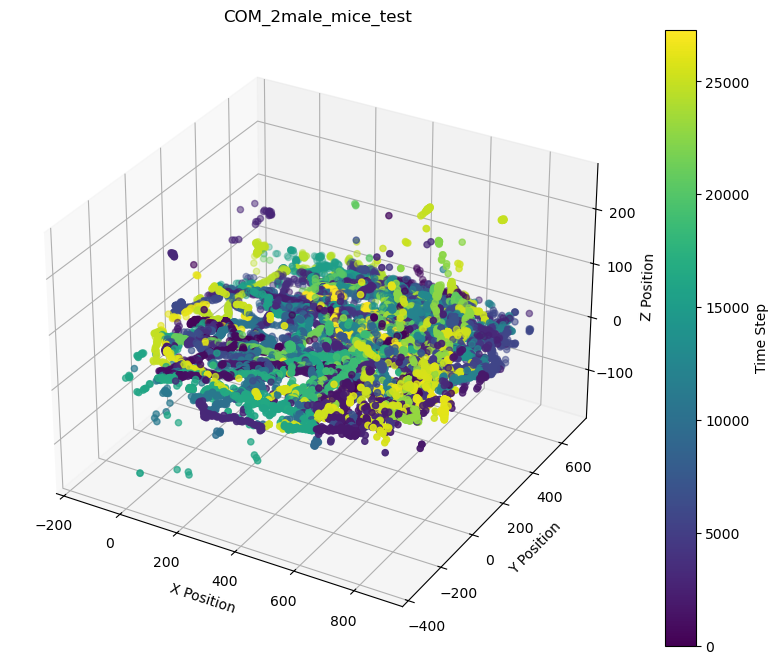

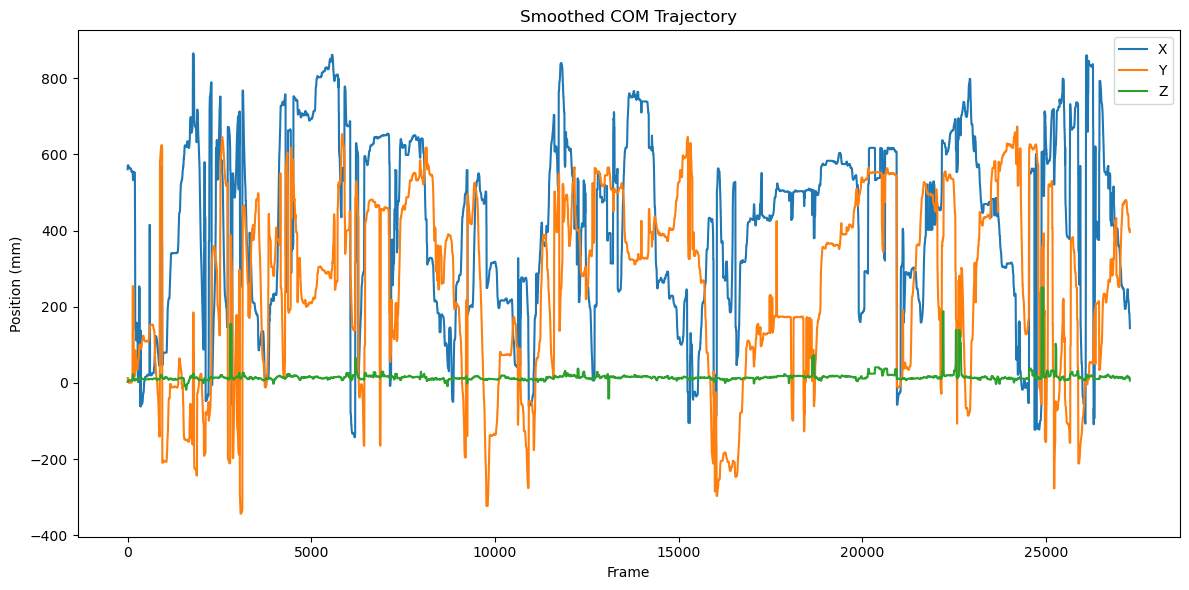

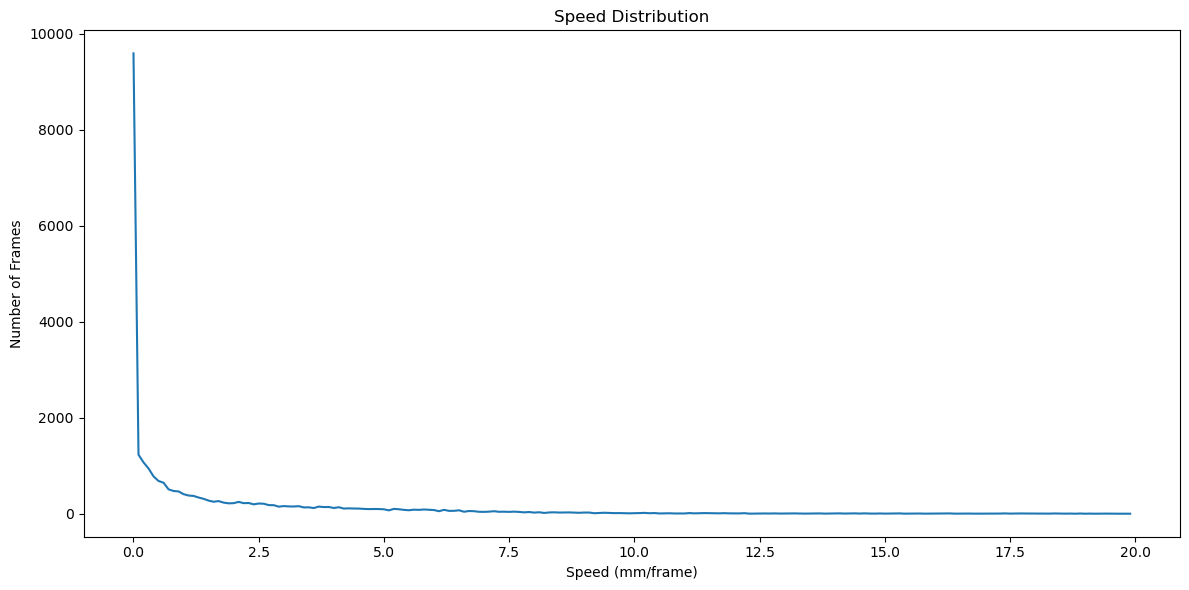

Analysis complete. Plots saved to: /hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_10_25/2male_mice_test/COM/predict00/vis
/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_10_25/2male_mice_test_miniscope
plotting com_traga for /hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_10_25/2male_mice_test_miniscope


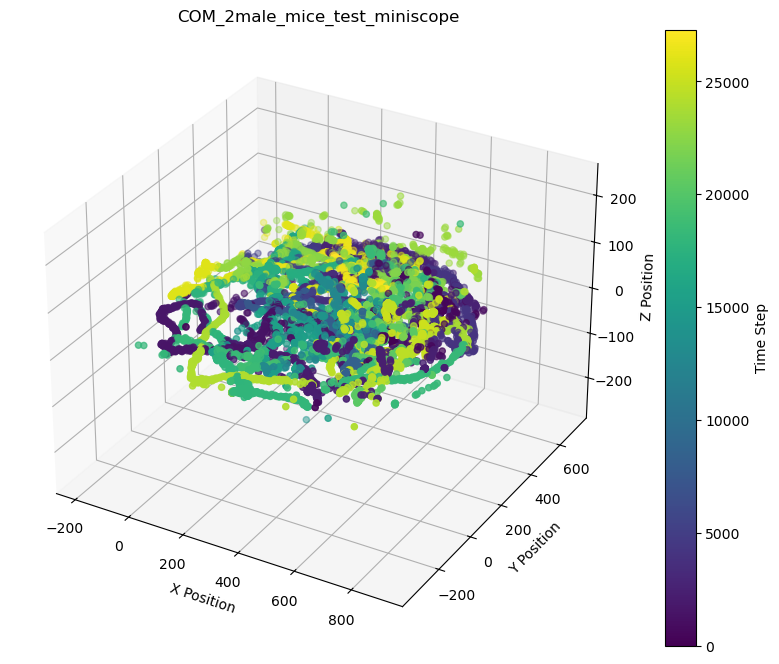

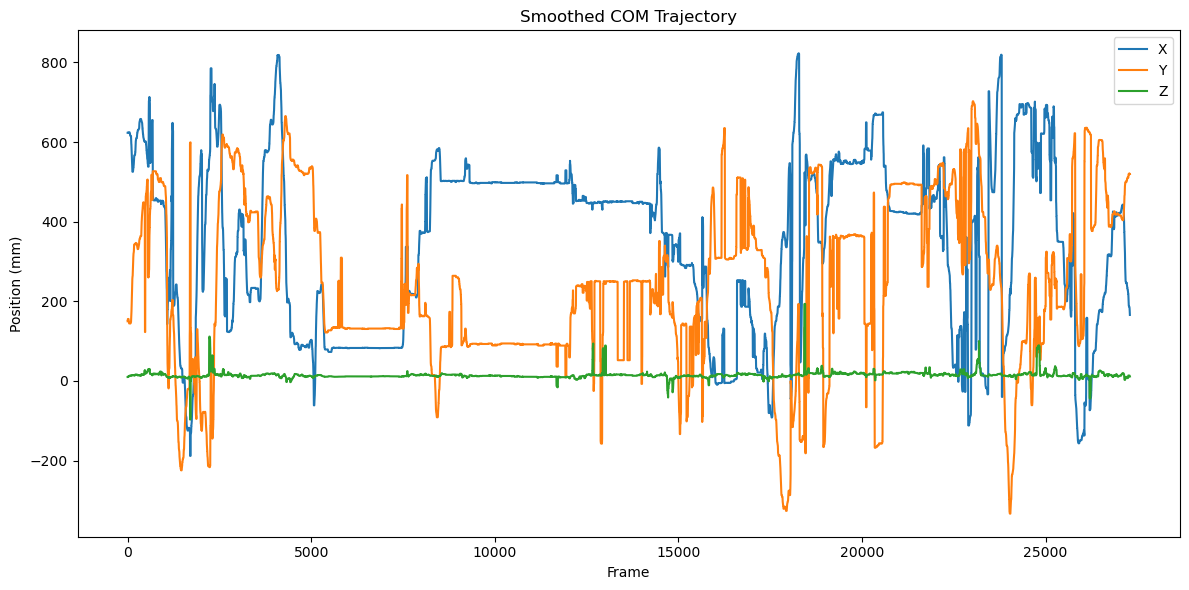

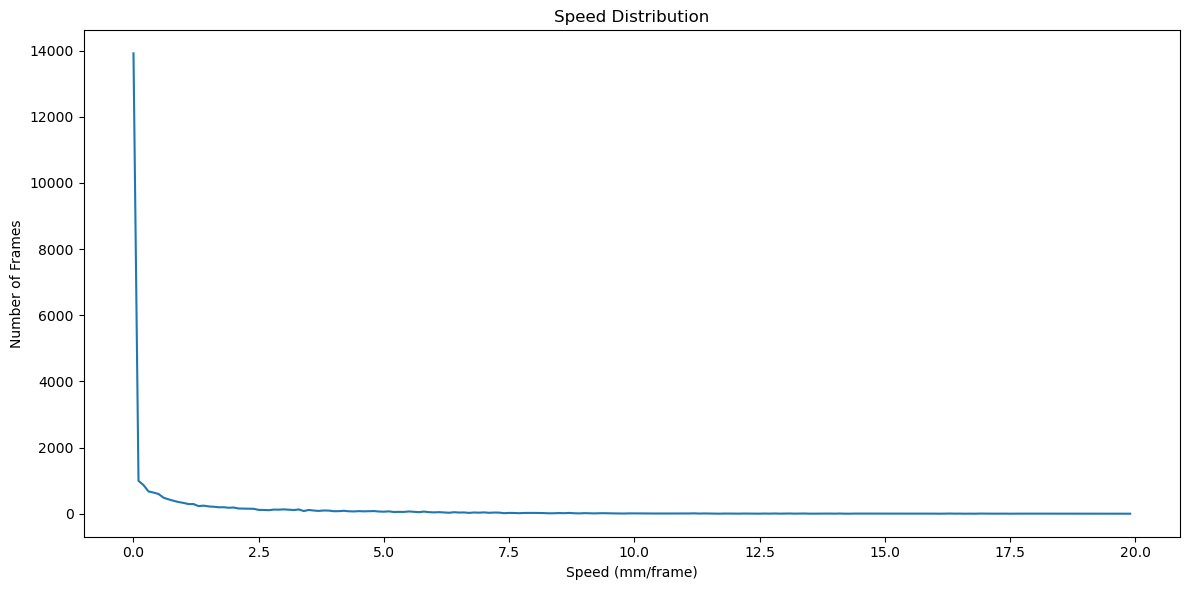

Analysis complete. Plots saved to: /hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_10_25/2male_mice_test_miniscope/COM/predict00/vis
/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_12_18/20240919v1l5r1mini_11_21
plotting com_traga for /hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_12_18/20240919v1l5r1mini_11_21


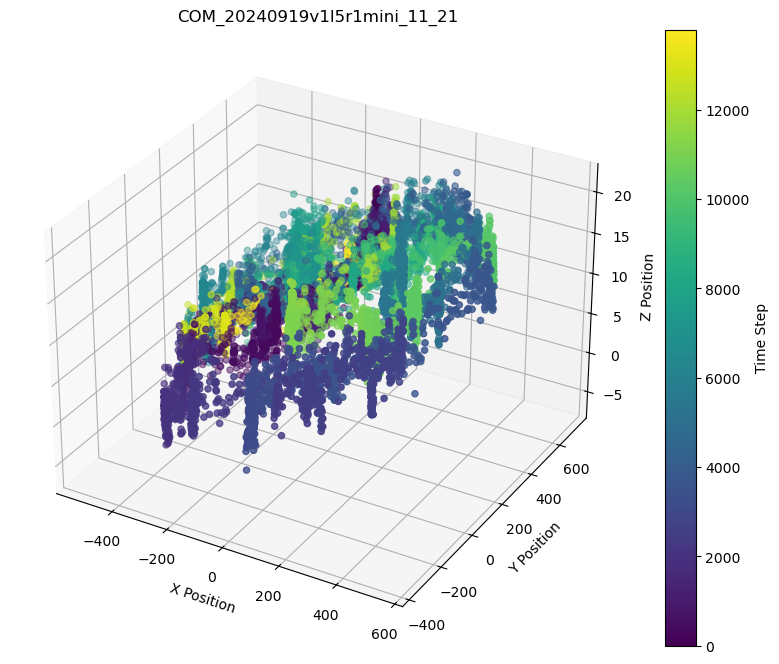

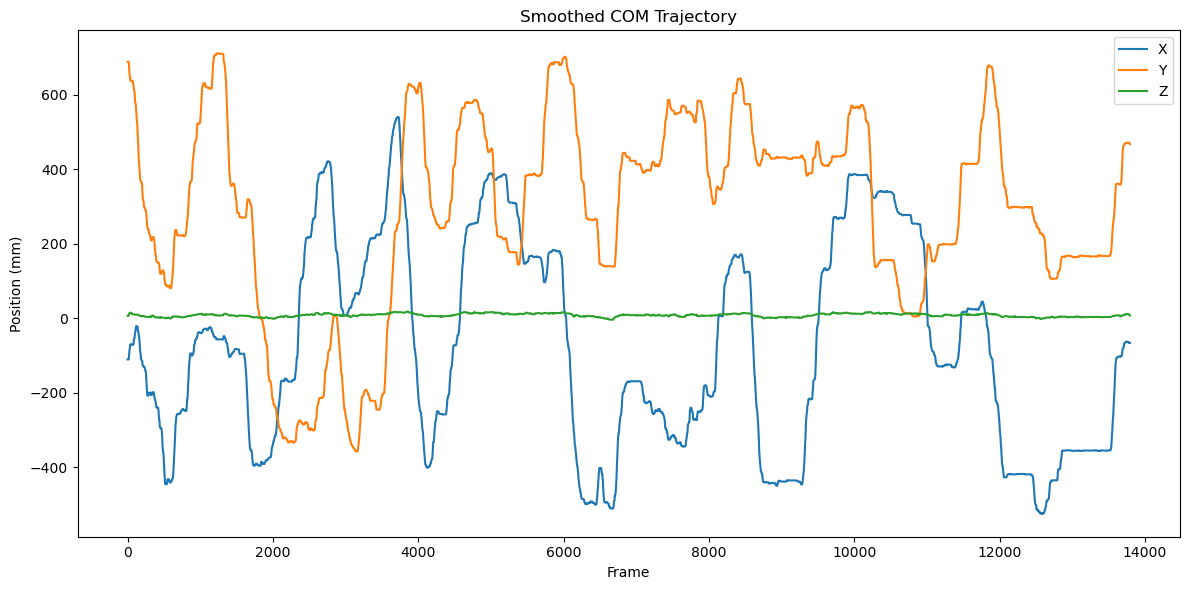

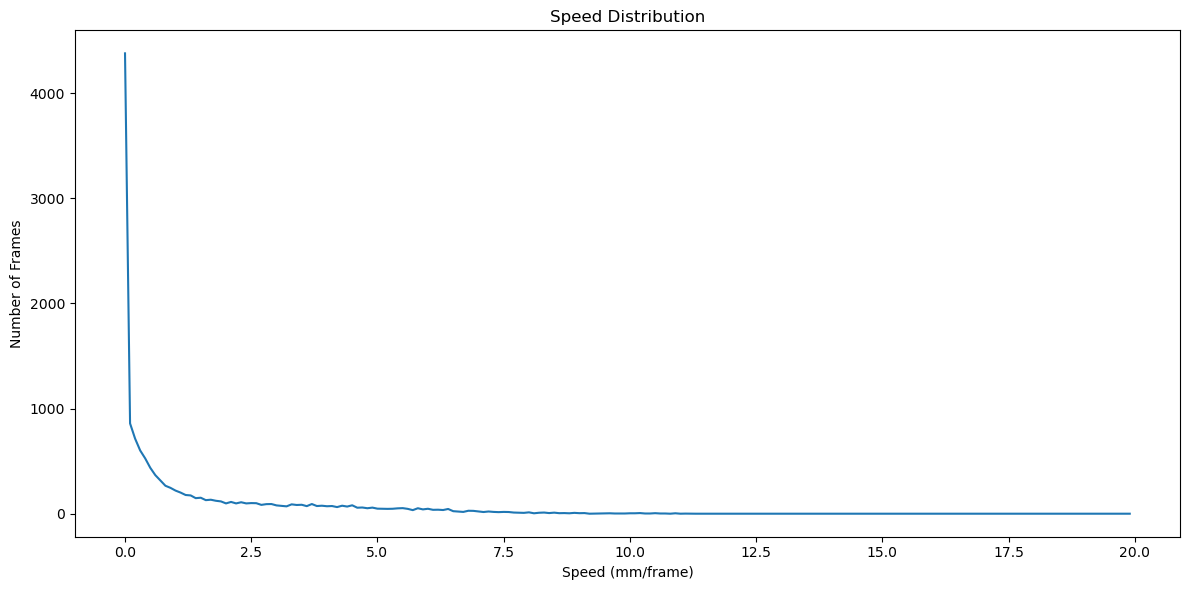

Analysis complete. Plots saved to: /hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_12_18/20240919v1l5r1mini_11_21/COM/predict00/vis
/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_12_18/20240919v1l5r2mini_13_09
plotting com_traga for /hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_12_18/20240919v1l5r2mini_13_09


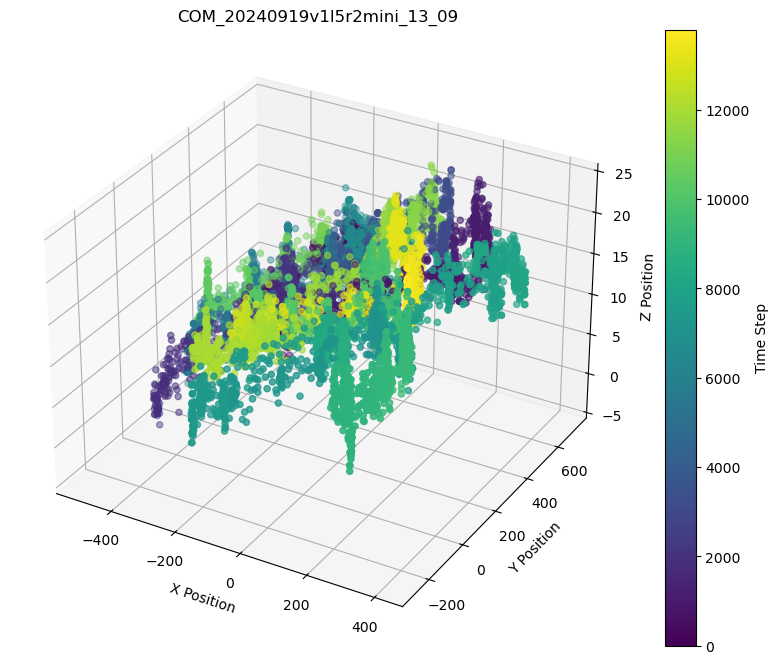

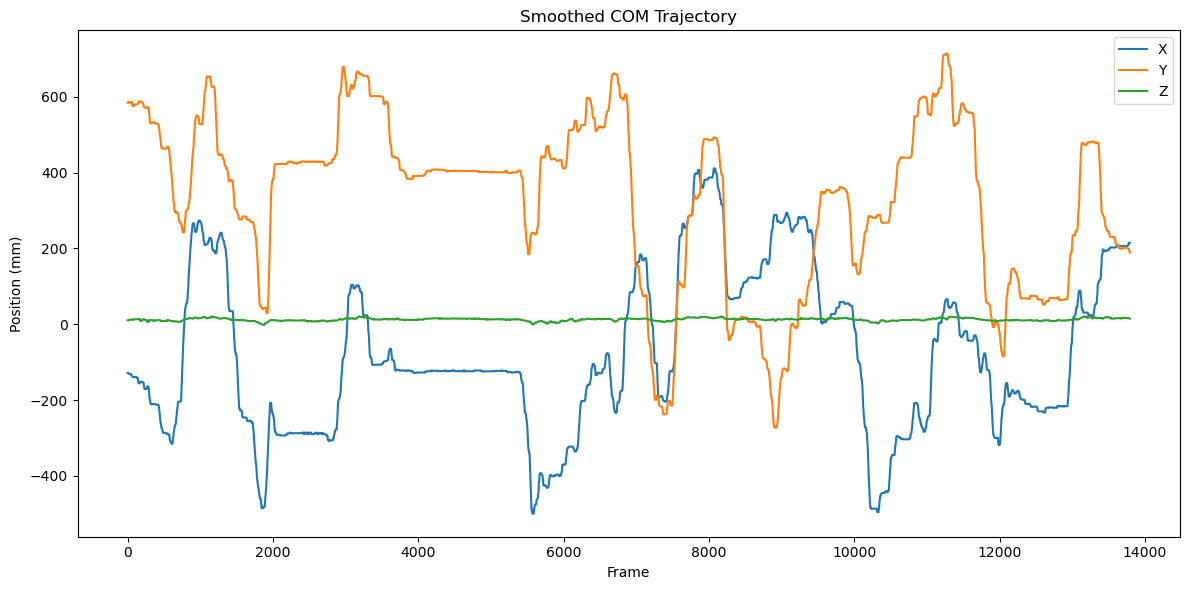

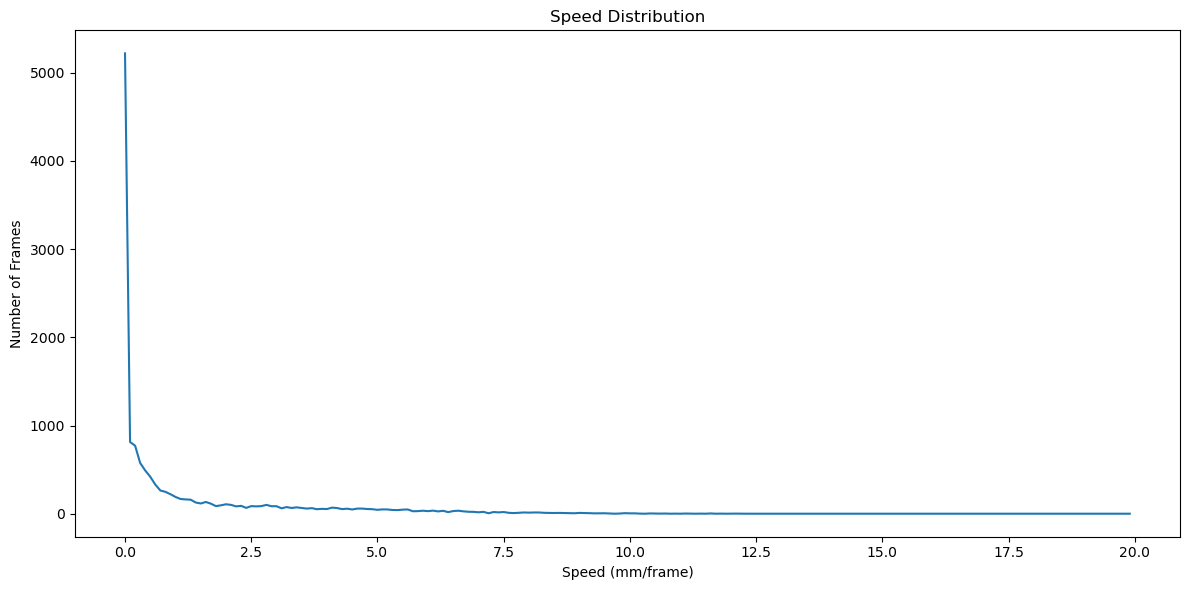

Analysis complete. Plots saved to: /hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_12_18/20240919v1l5r2mini_13_09/COM/predict00/vis
/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_12_31/20240919v1l5r2mini_13_54
plotting com_traga for /hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_12_31/20240919v1l5r2mini_13_54


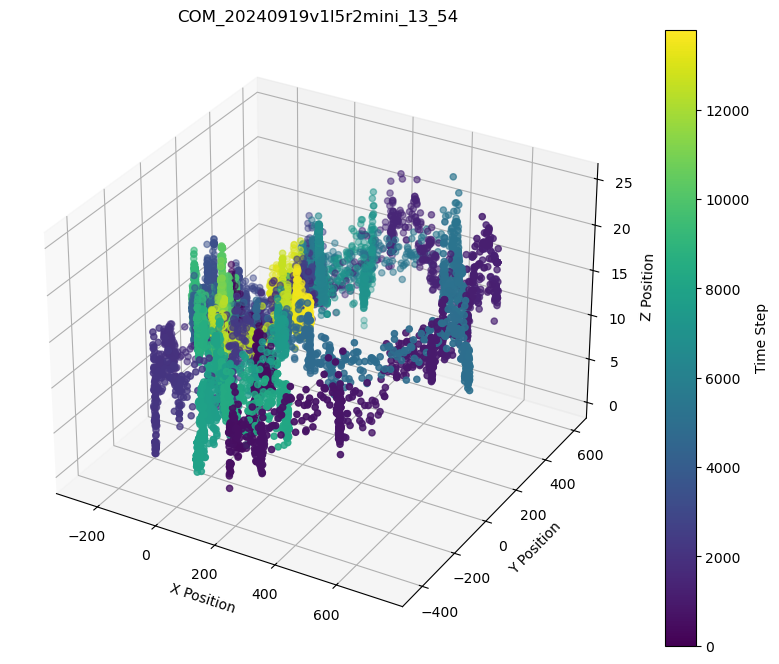

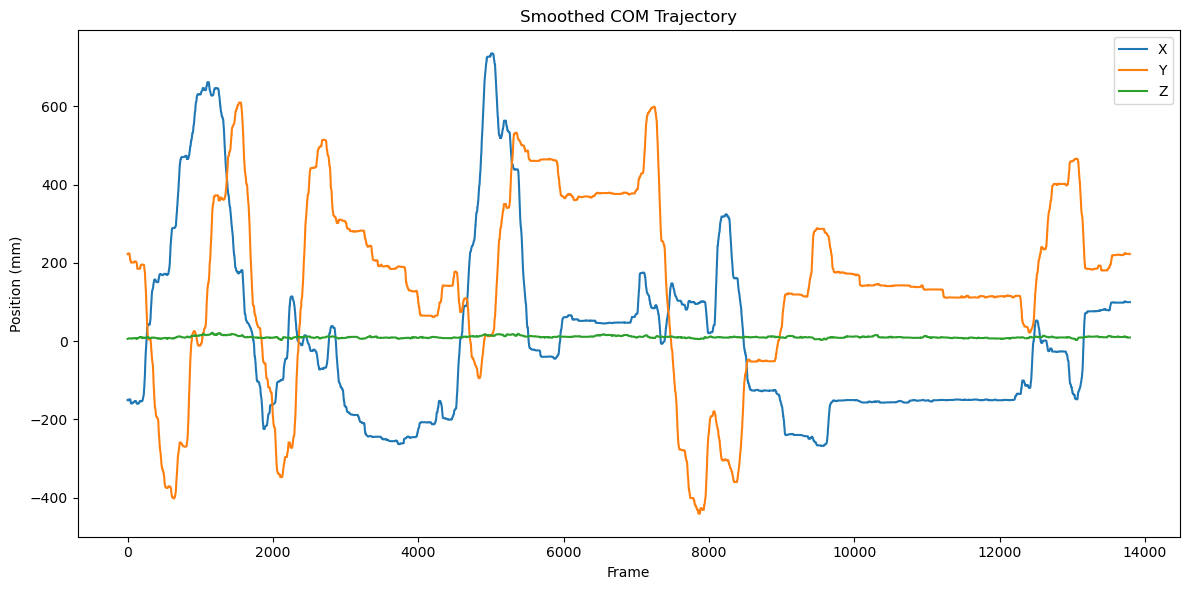

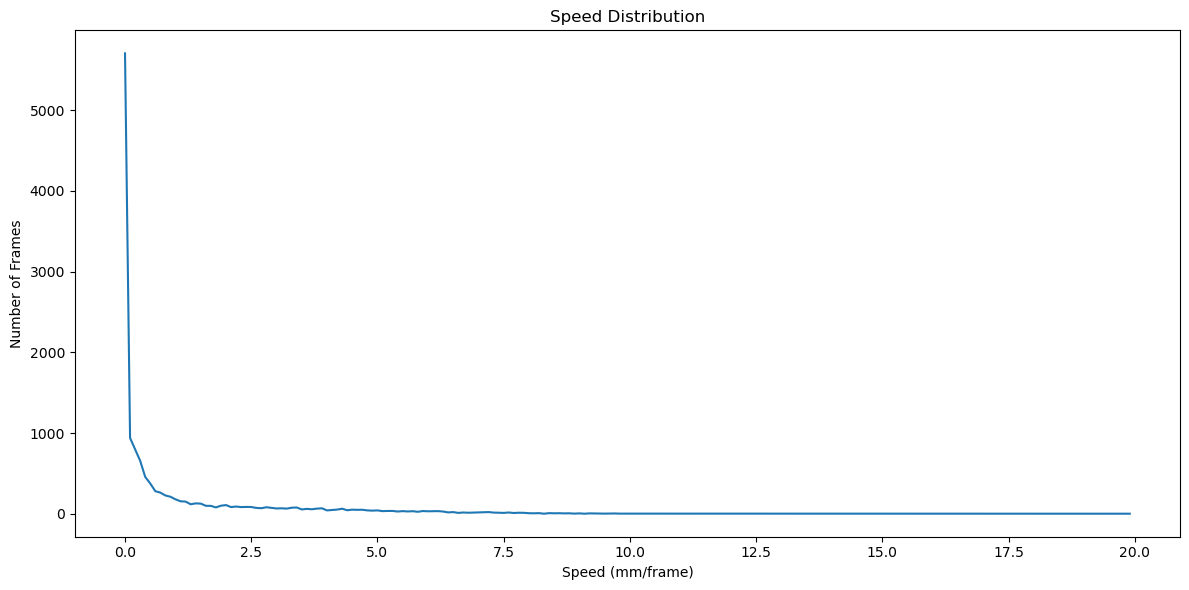

Analysis complete. Plots saved to: /hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_12_31/20240919v1l5r2mini_13_54/COM/predict00/vis
/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_12_31/20241212v1l1r1mini_11_22
plotting com_traga for /hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_12_31/20241212v1l1r1mini_11_22


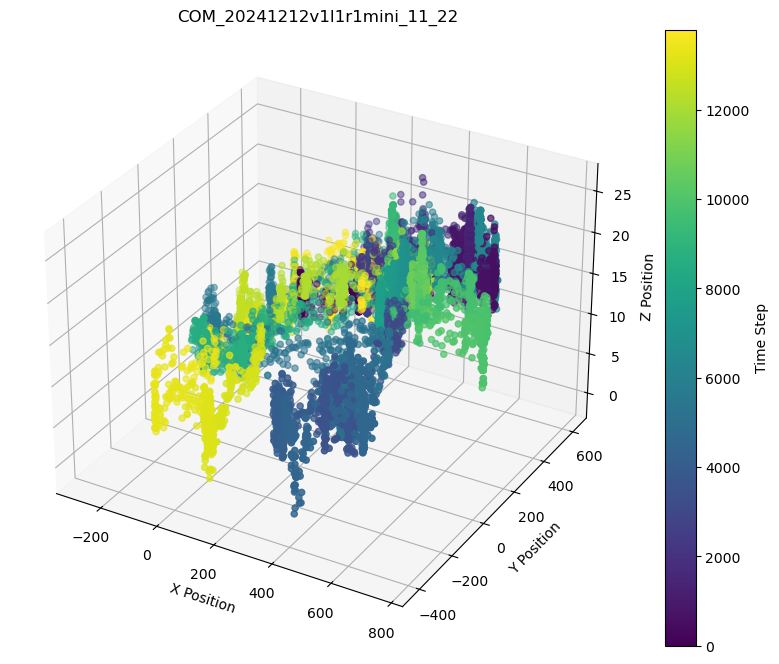

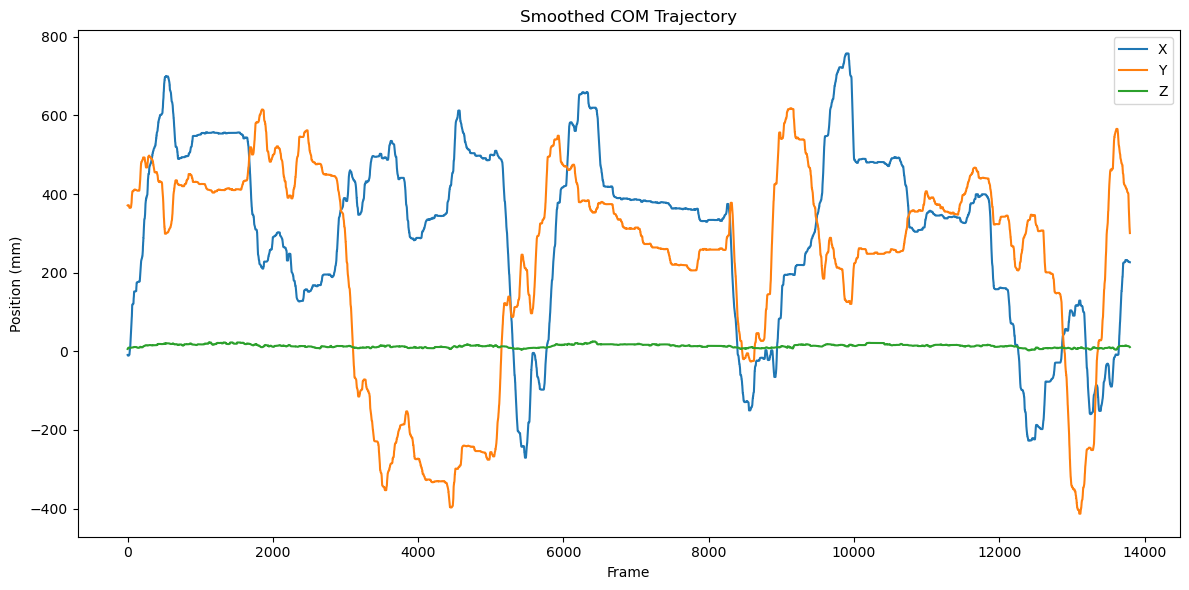

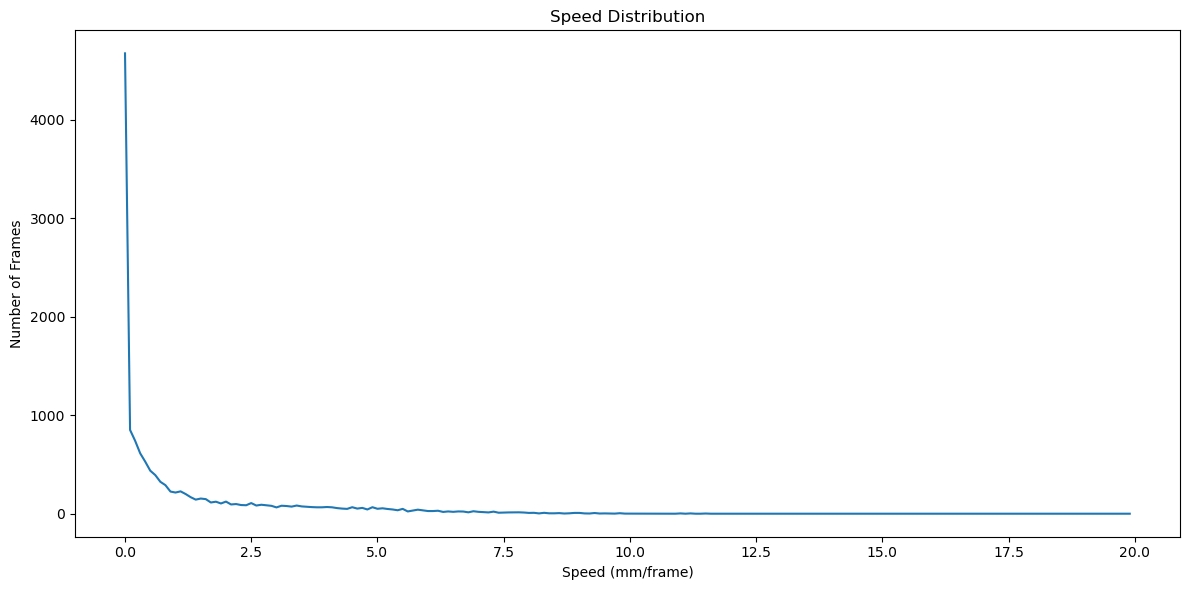

Analysis complete. Plots saved to: /hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_12_31/20241212v1l1r1mini_11_22/COM/predict00/vis
/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_12_31/20241212v1l1r2mini_12_04
plotting com_traga for /hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_12_31/20241212v1l1r2mini_12_04


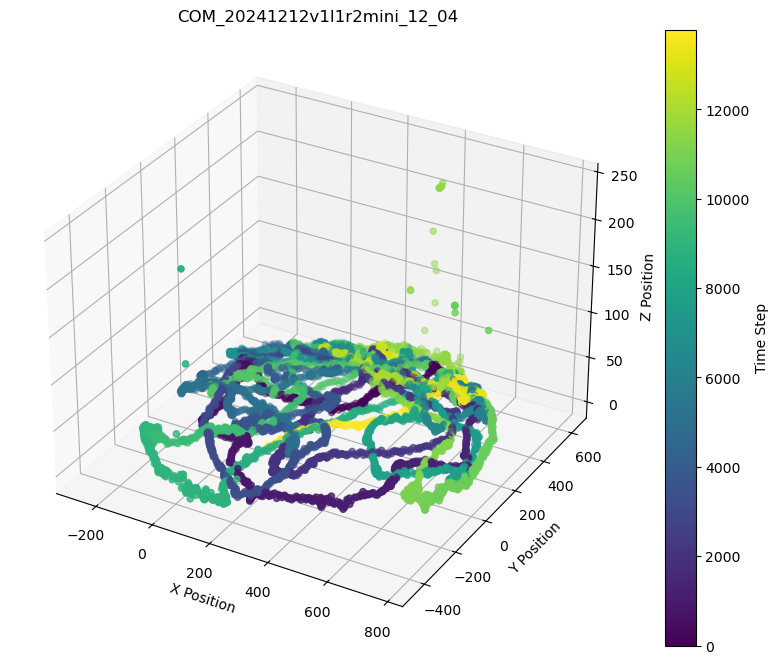

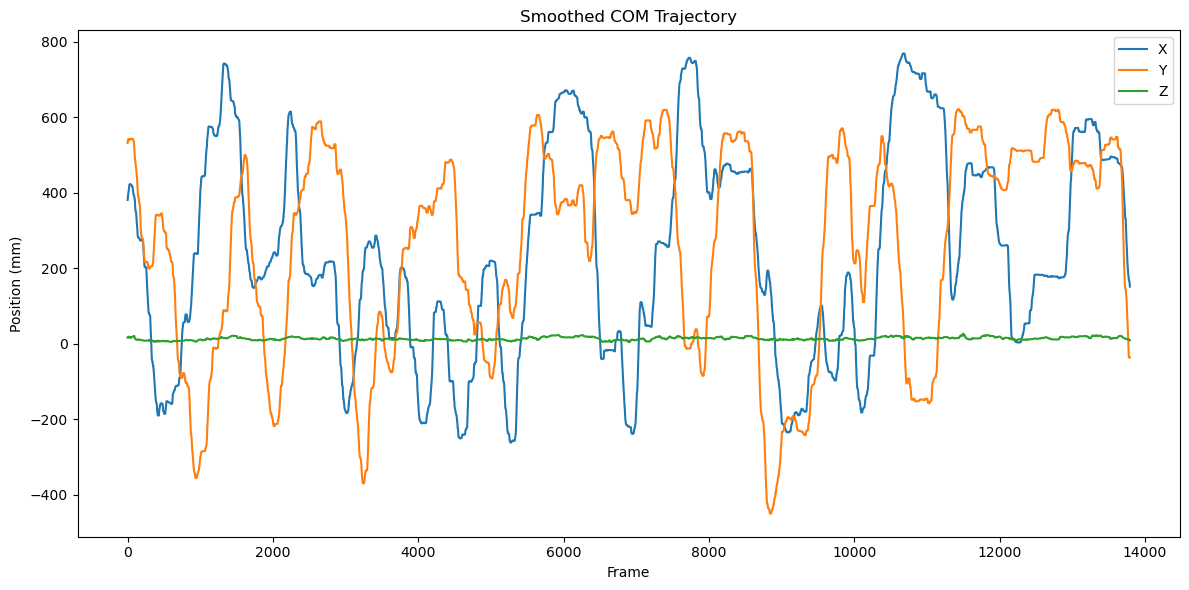

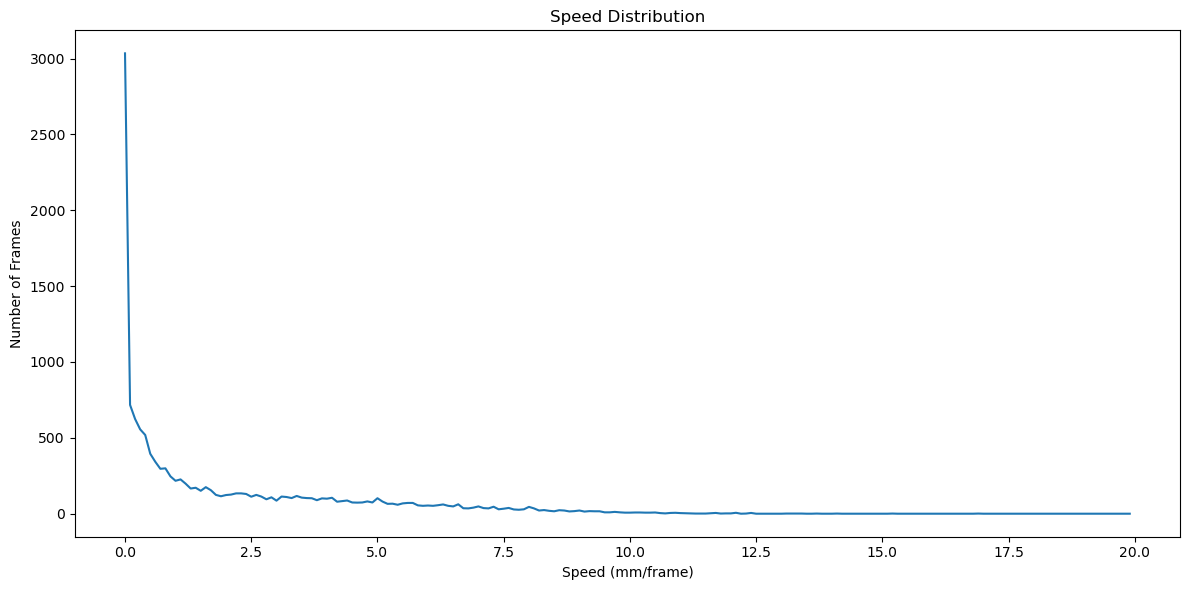

Analysis complete. Plots saved to: /hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_12_31/20241212v1l1r2mini_12_04/COM/predict00/vis
/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2025_02_12/20241001PMCRE2mini_13_44
plotting com_traga for /hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2025_02_12/20241001PMCRE2mini_13_44


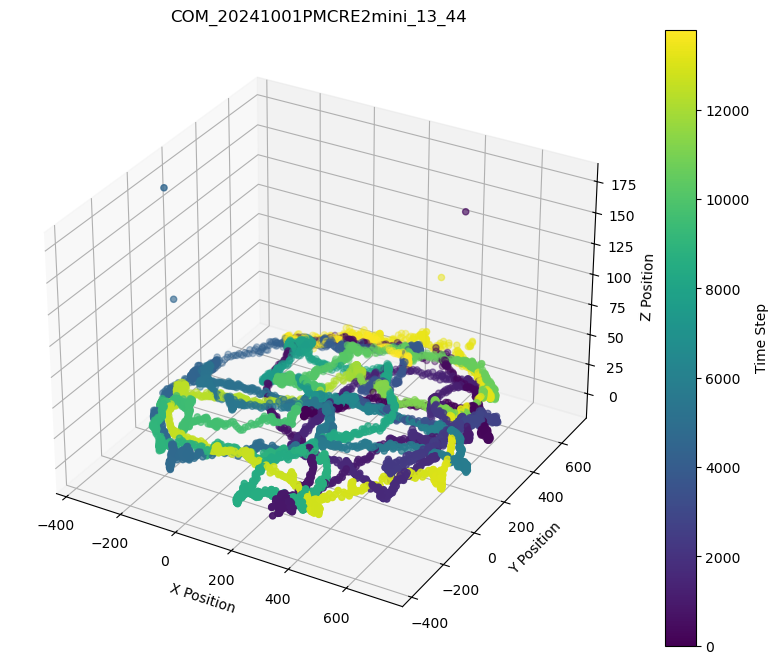

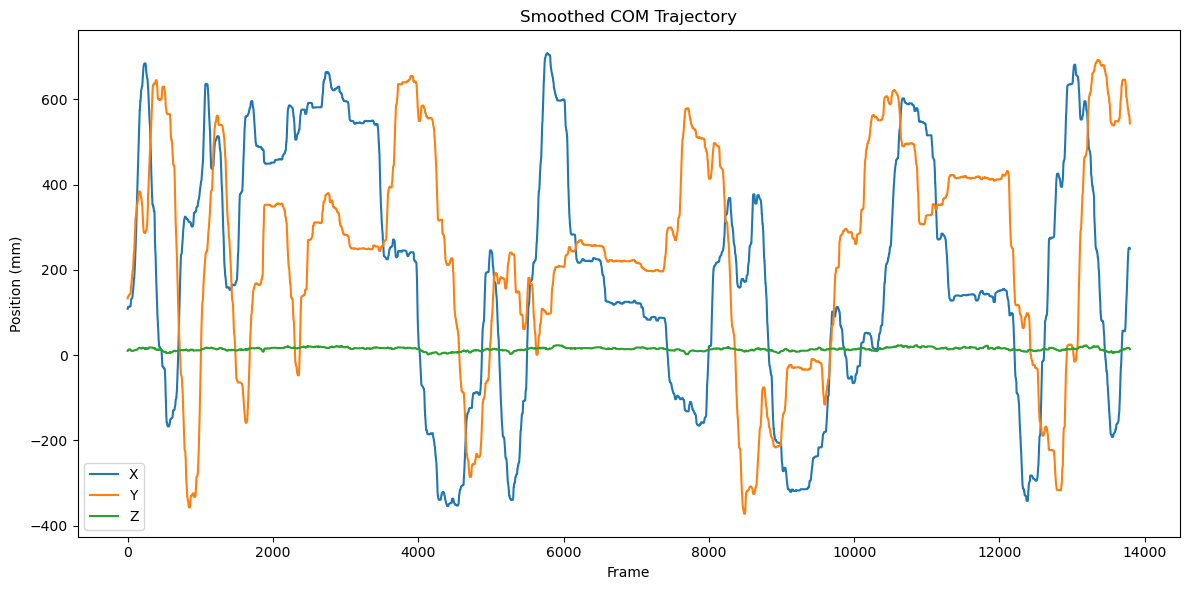

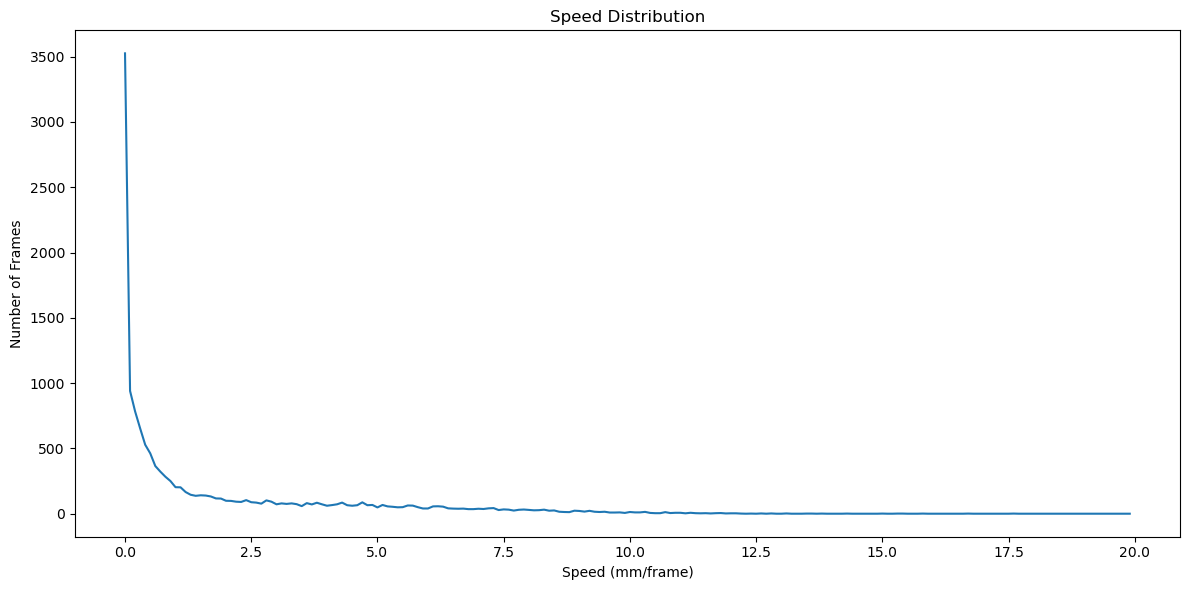

Analysis complete. Plots saved to: /hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2025_02_12/20241001PMCRE2mini_13_44/COM/predict00/vis
/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2025_02_12/20241001PMCRE2mini_13_57
plotting com_traga for /hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2025_02_12/20241001PMCRE2mini_13_57


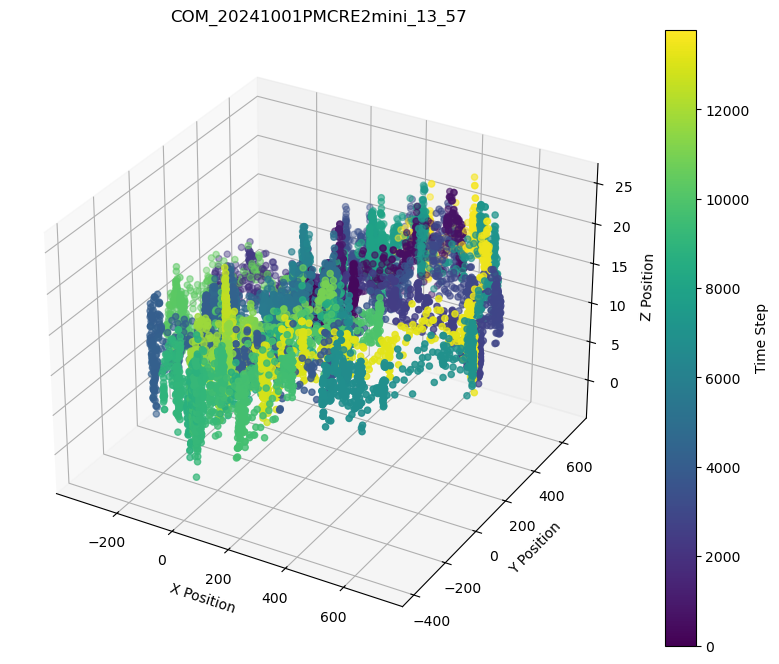

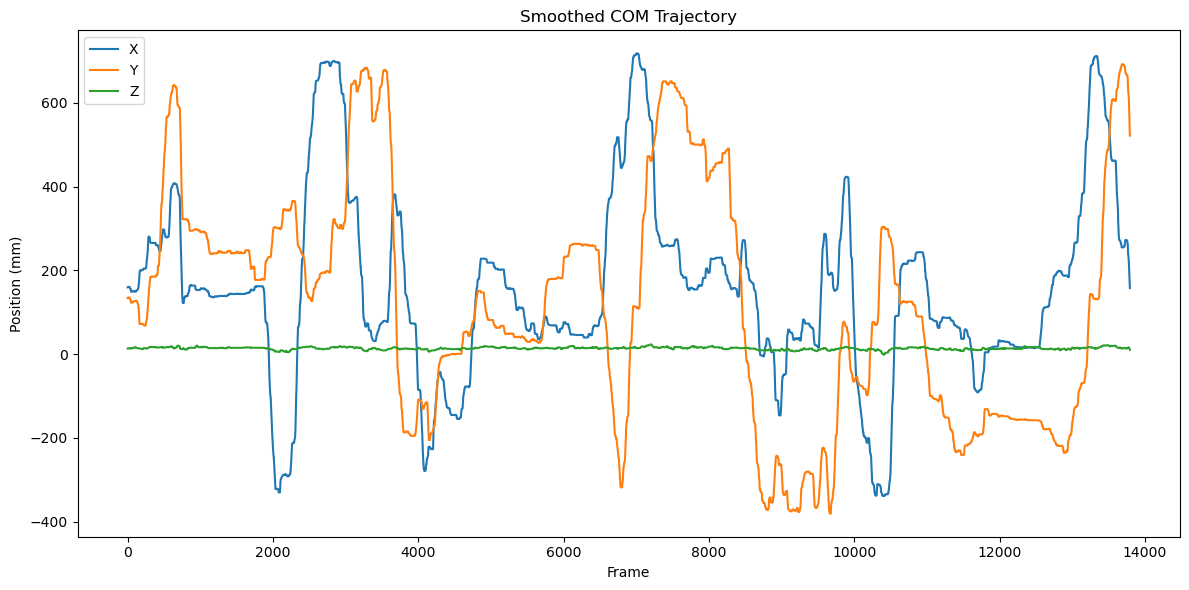

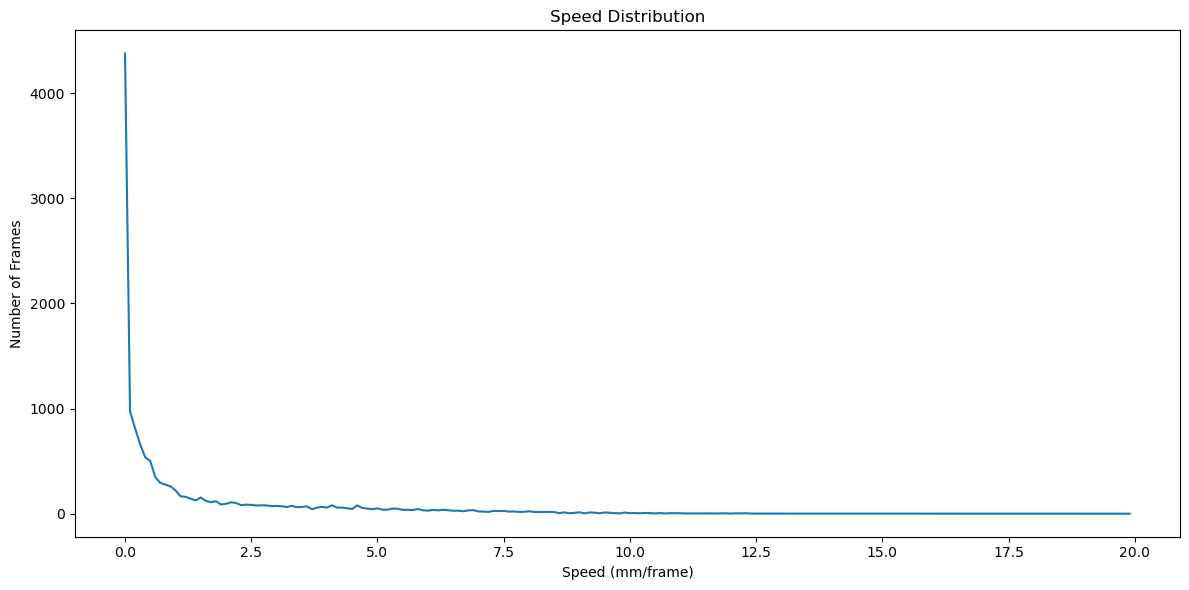

Analysis complete. Plots saved to: /hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2025_02_12/20241001PMCRE2mini_13_57/COM/predict00/vis
/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2025_02_12/20241001PMCRE2mini_15_22
plotting com_traga for /hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2025_02_12/20241001PMCRE2mini_15_22


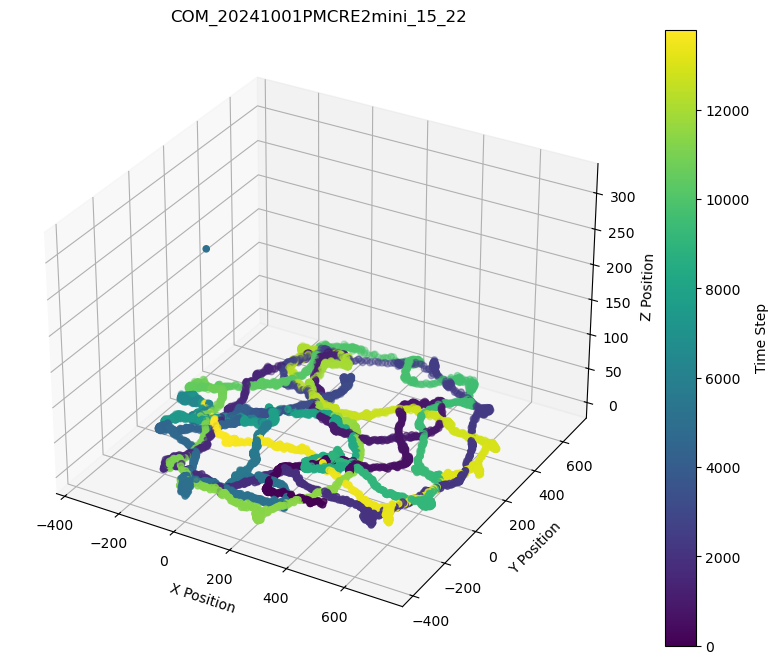

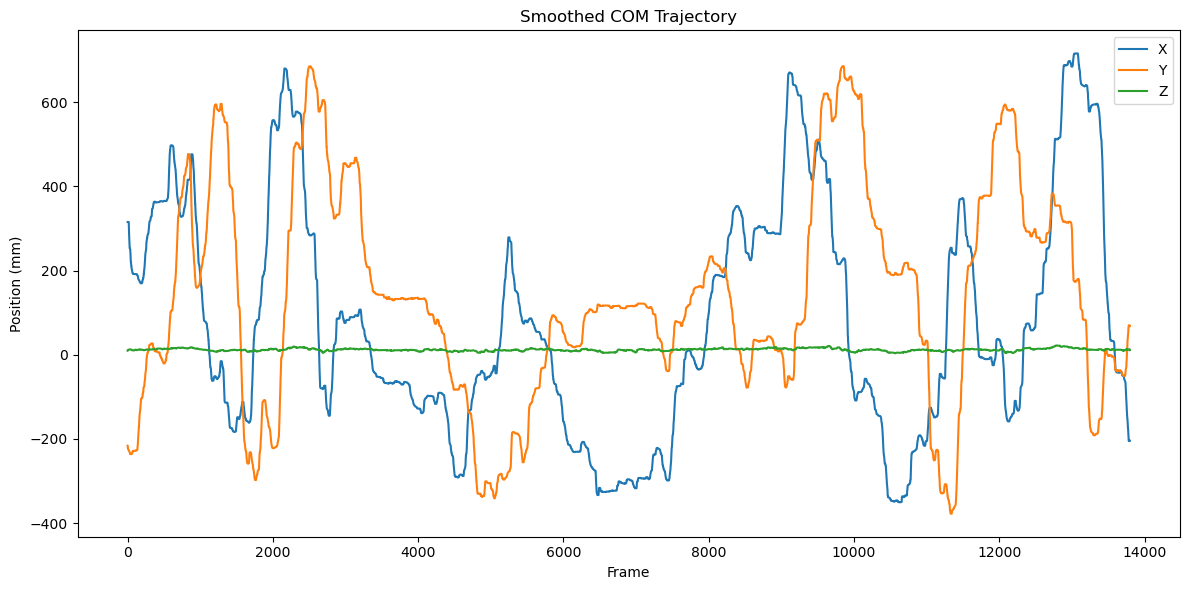

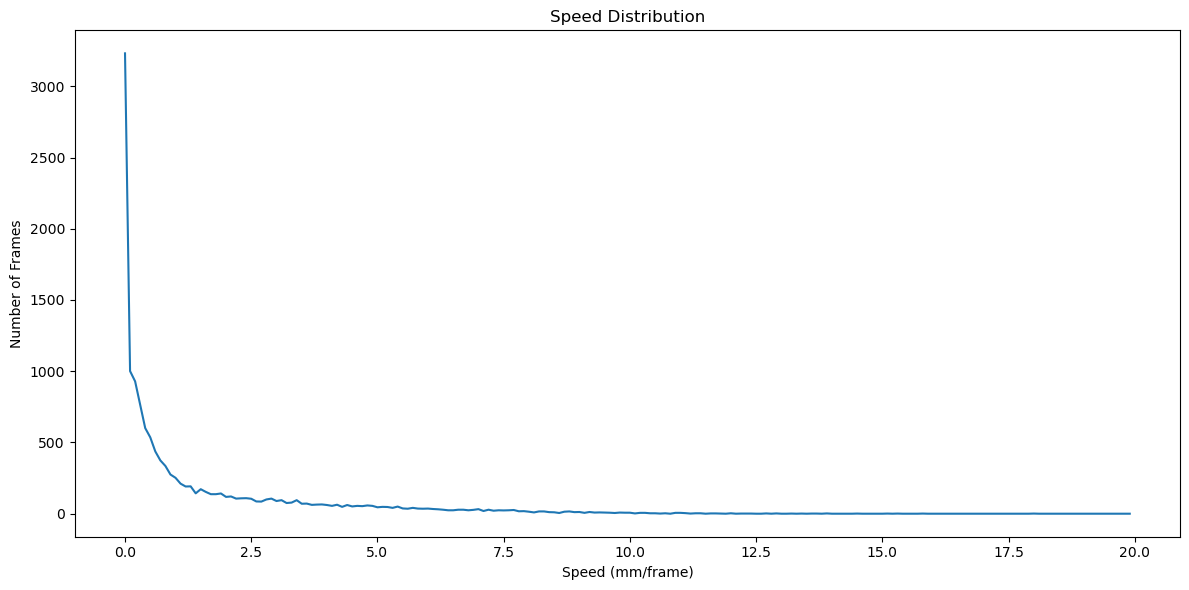

Analysis complete. Plots saved to: /hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2025_02_12/20241001PMCRE2mini_15_22/COM/predict00/vis
/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2025_02_12/20241001PMCRE2mini_15_35
plotting com_traga for /hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2025_02_12/20241001PMCRE2mini_15_35


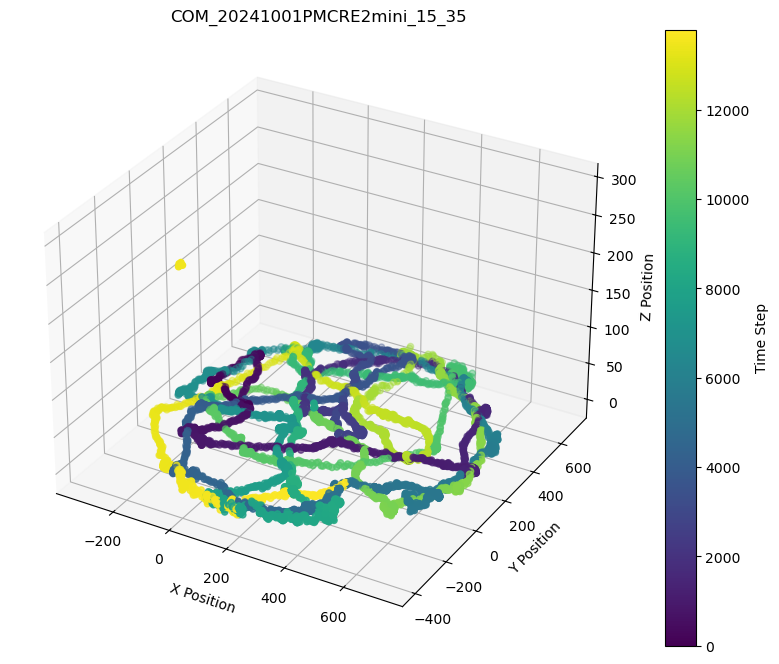

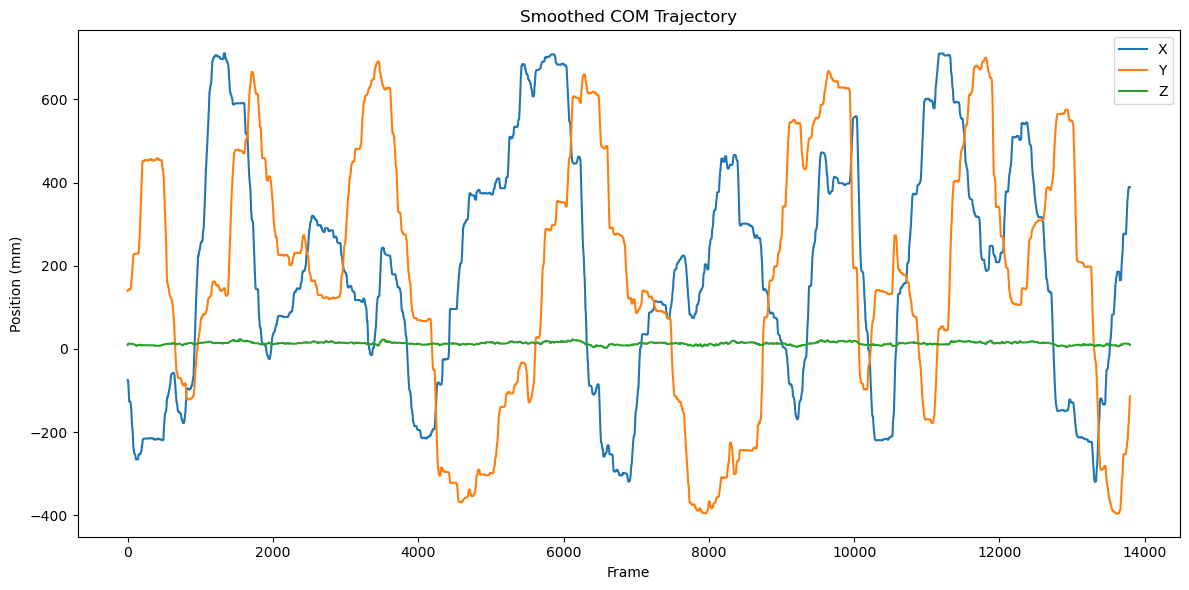

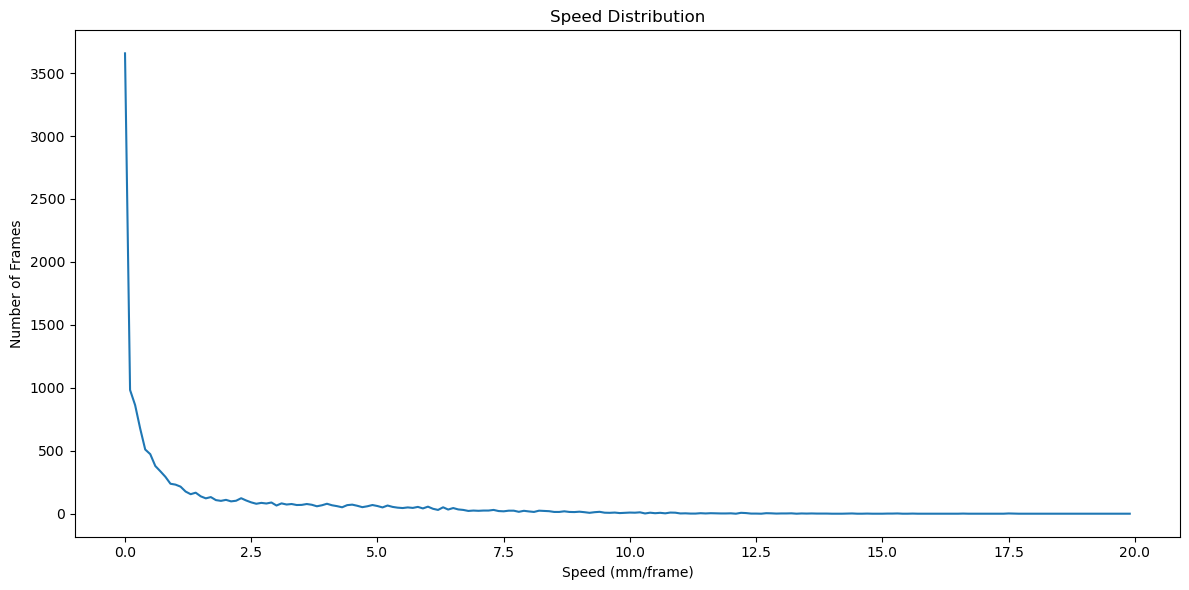

Analysis complete. Plots saved to: /hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2025_02_12/20241001PMCRE2mini_15_35/COM/predict00/vis
/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2025_02_13/20241225PMCLE1mini_11_06
plotting com_traga for /hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2025_02_13/20241225PMCLE1mini_11_06


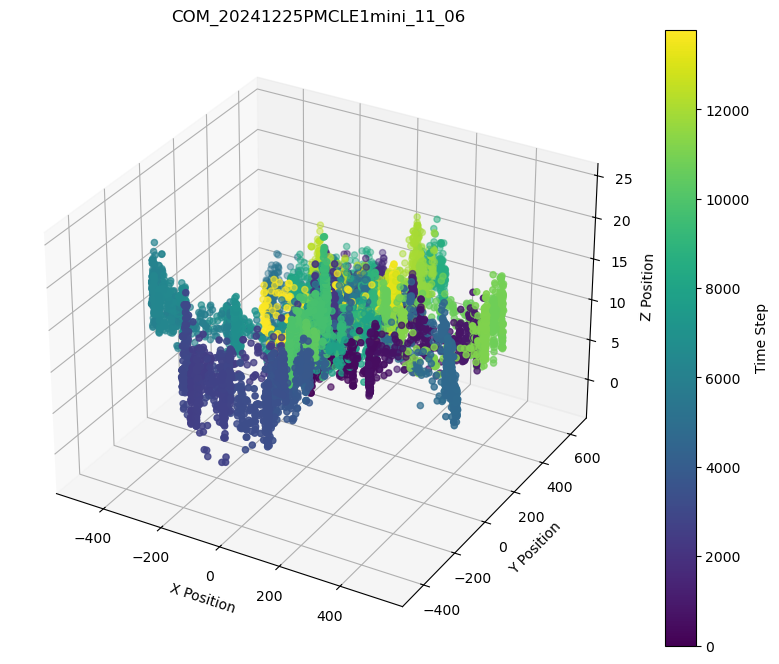

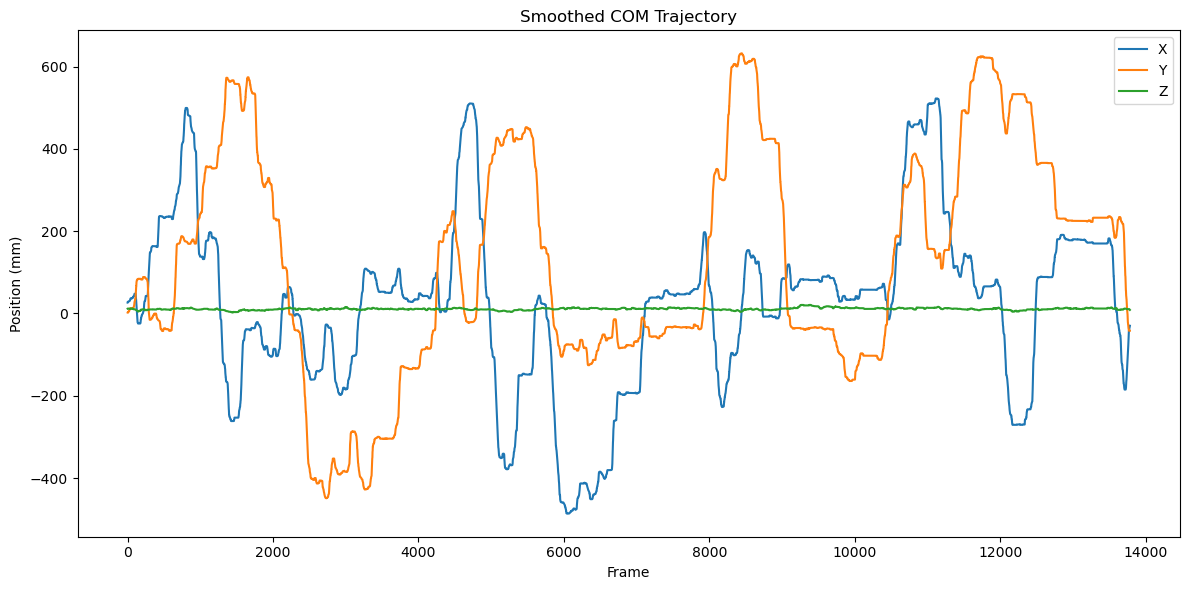

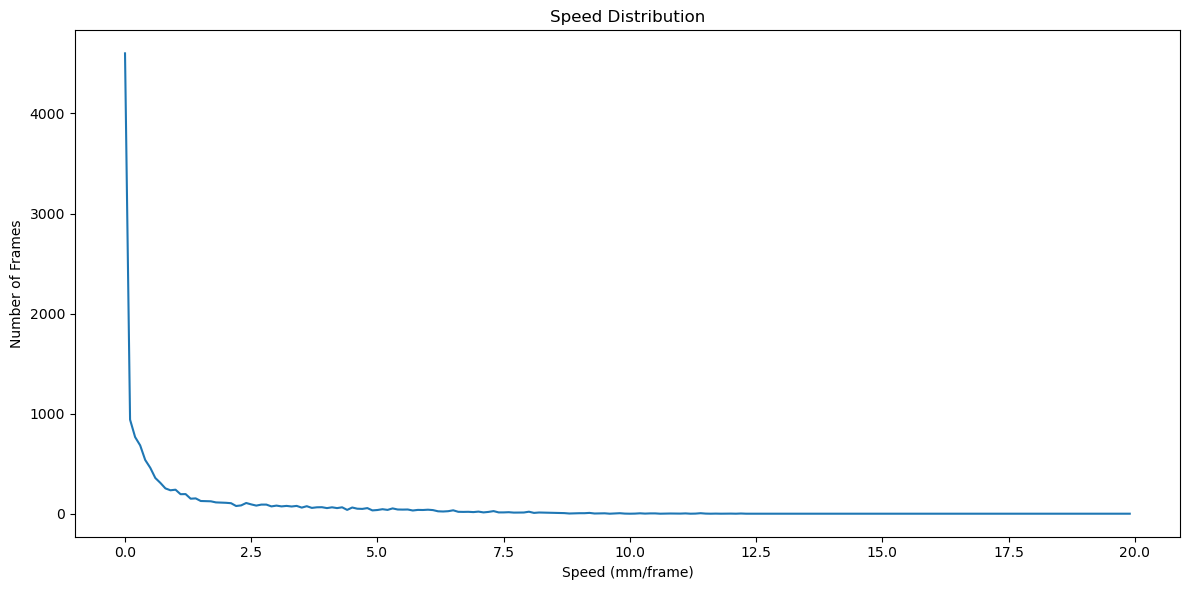

Analysis complete. Plots saved to: /hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2025_02_13/20241225PMCLE1mini_11_06/COM/predict00/vis
/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2025_02_13/20241225PMCLE1mini_11_23
plotting com_traga for /hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2025_02_13/20241225PMCLE1mini_11_23


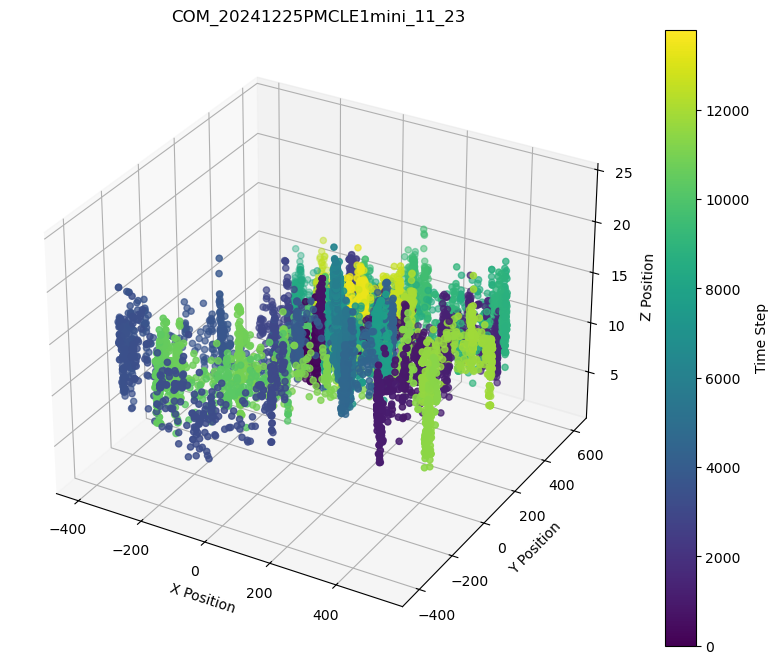

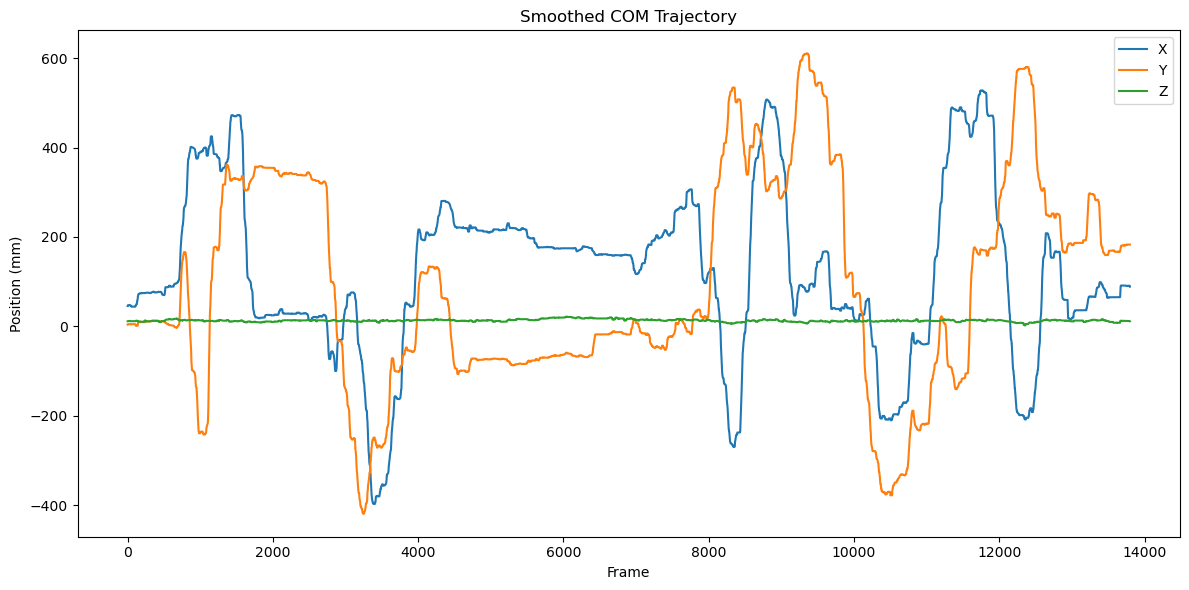

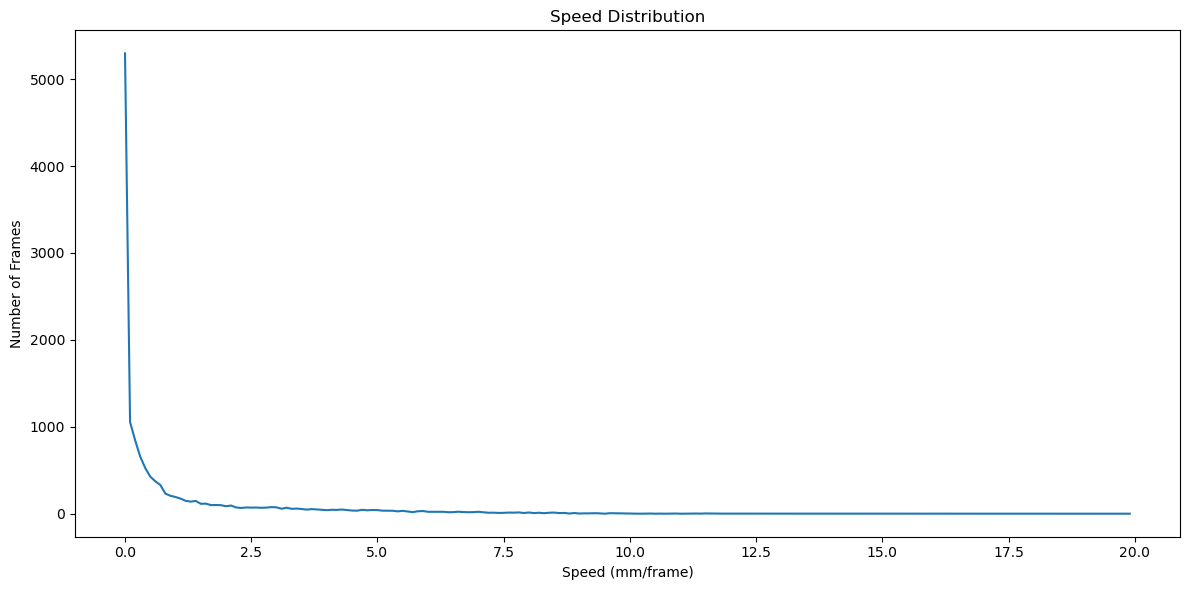

Analysis complete. Plots saved to: /hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2025_02_13/20241225PMCLE1mini_11_23/COM/predict00/vis
/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2025_02_13/20241225PMCLE1mini_11_37
plotting com_traga for /hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2025_02_13/20241225PMCLE1mini_11_37


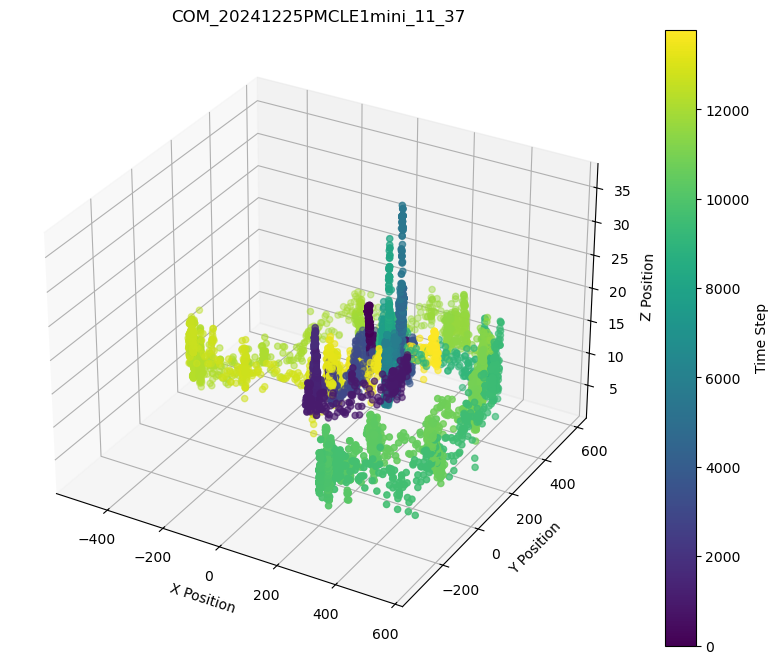

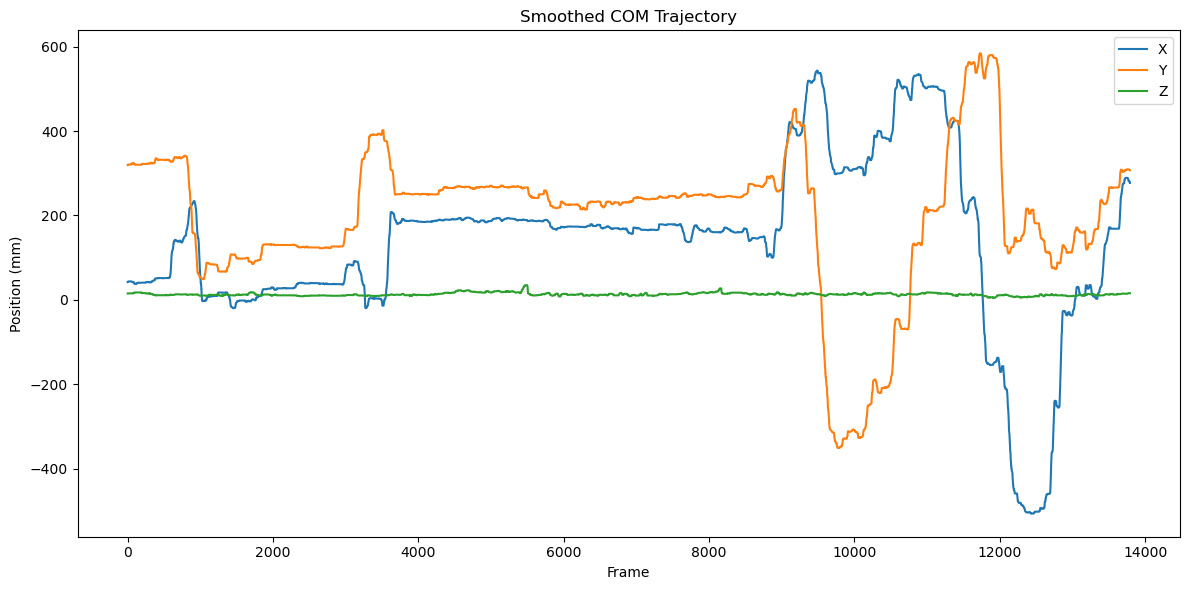

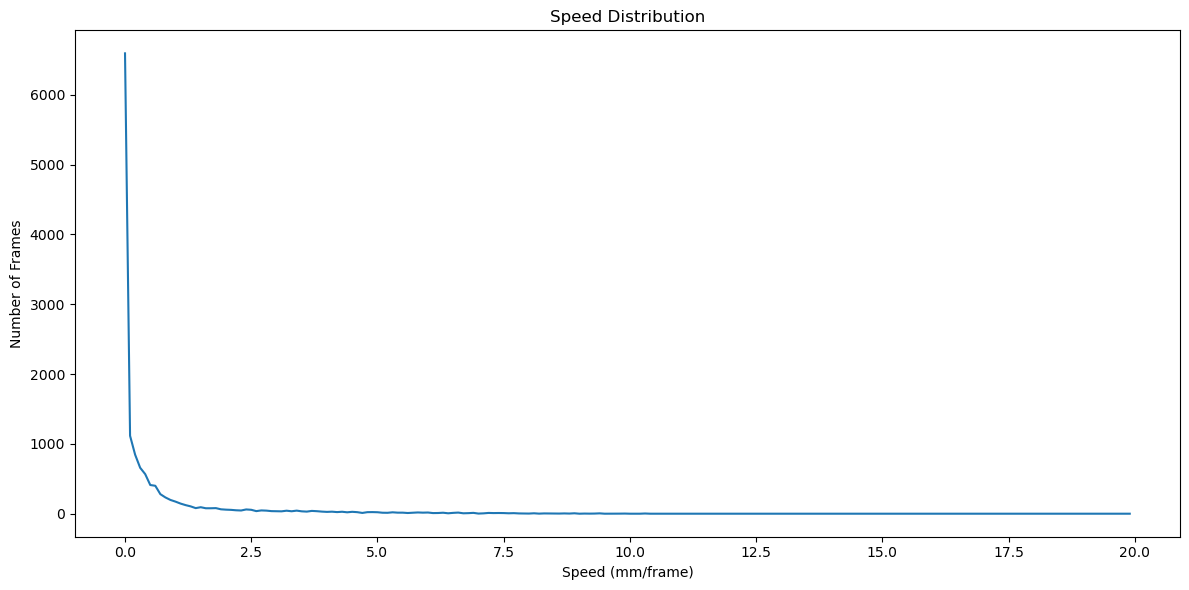

Analysis complete. Plots saved to: /hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2025_02_13/20241225PMCLE1mini_11_37/COM/predict00/vis
/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2025_02_13/20241225PMCLE1mini_11_57
plotting com_traga for /hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2025_02_13/20241225PMCLE1mini_11_57


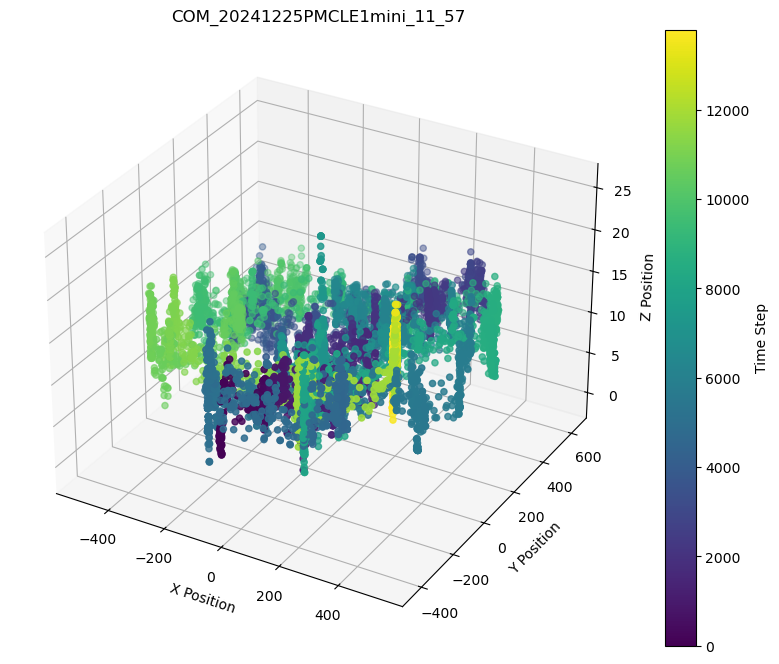

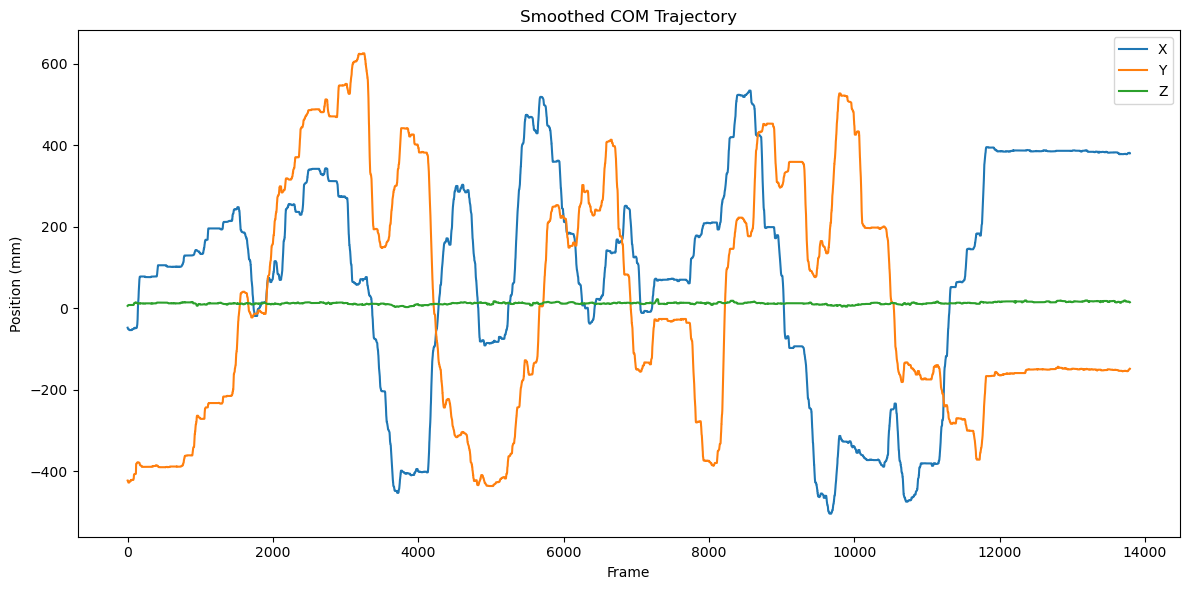

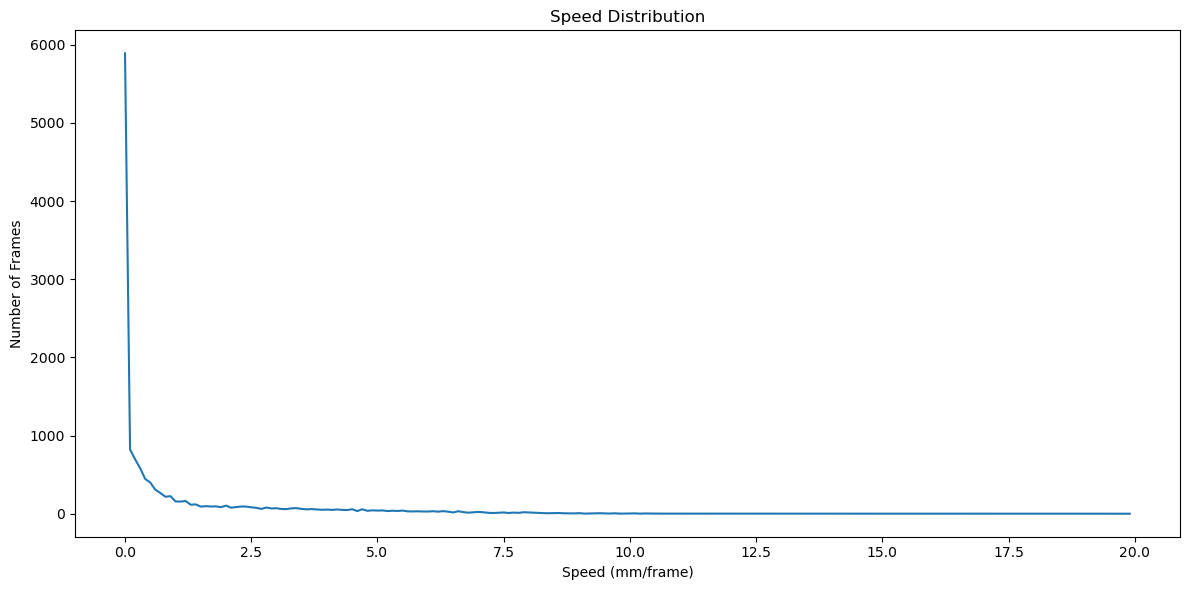

Analysis complete. Plots saved to: /hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2025_02_13/20241225PMCLE1mini_11_57/COM/predict00/vis
/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2025_02_27/20241015PMCBE1mini_12_24
plotting com_traga for /hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2025_02_27/20241015PMCBE1mini_12_24


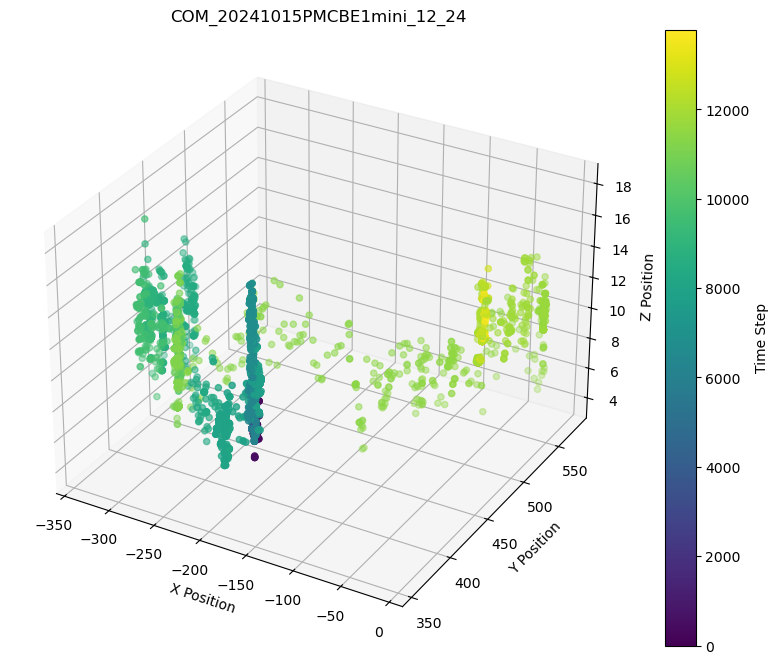

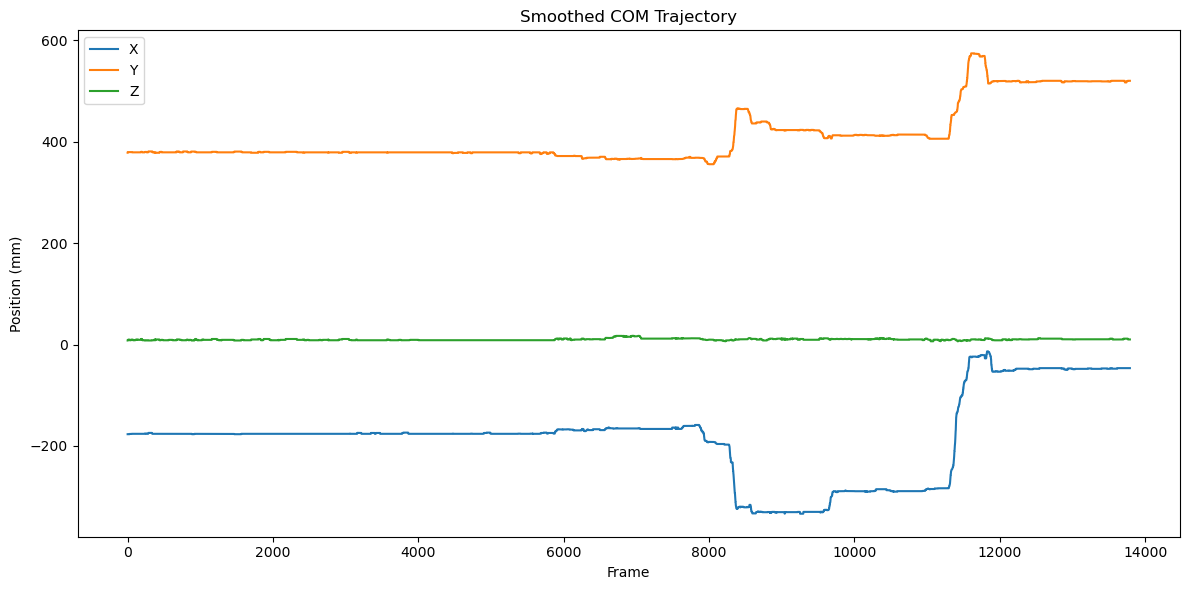

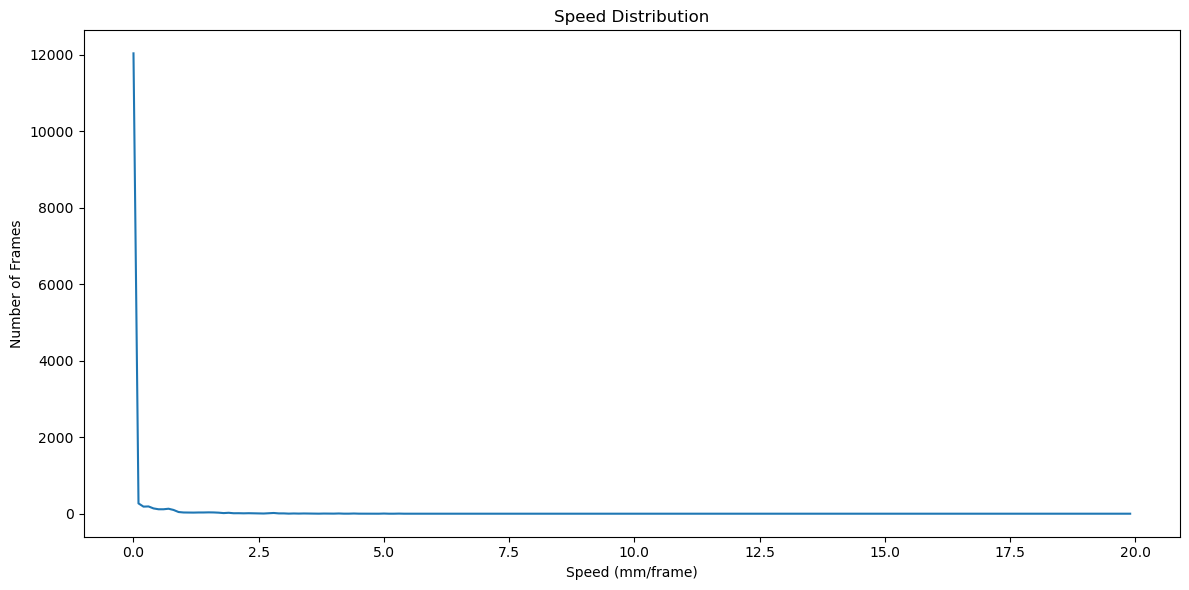

Analysis complete. Plots saved to: /hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2025_02_27/20241015PMCBE1mini_12_24/COM/predict00/vis


In [9]:
from utlis.vis_valid_utlis.com_trag_updated import plot_com_all

# Assume base_folder is defined elsewhere in your script
# base_folder = '/path/to/your/base/folder'

records = [
    {
        'date_folder': date_folder.as_py(),  # Convert to string using as_py()
        'rec_file': rec_file.as_py()         # Convert to string using as_py()
    }
    for date_folder, rec_file in zip(for_com_vis['date_folder'], for_com_vis['rec_file'])
]

# Iterate through the records and process each one sequentially
for record in records:
    base_path = f"{base_folder}/{record['date_folder']}/{record['rec_file']}"
    print(base_path)
    try:
        plot_com_all(base_path) #com_folder_name='COM/predict00', perform_jump_indices=True, perform_video_generation=False, perform_generate_com_video=False
    except Exception as e:
        print(f"An error occurred while processing {base_path}: {e}")
        # Skip to the next record if an error occurs
        continue

In [11]:
import pyarrow.compute as pc
table = all_df  # combined_df

# Filter dropf_handle == 1, com != 1, and social != 1
# filter_mask = pc.and_(
#     # pc.equal(table['dropf_handle'], '1'),
#     pc.equal(table['com'], '1'),
#     pc.not_equal(table['dannce'], '1'),
#     # pc.and_(
#     #     pc.equal(table['sync'], '1'),
#     #     pc.not_equal(table['dannce'], '1'),
#     # )
#     # pc.not_equal(table['social'], '1')
# )

filter_mask = pc.and_(

        pc.equal(table['com'], '1'),
                pc.not_equal(table['social'], '1')
    # pc.equal(table['sync'], '1'),
    # pc.not_equal(table['com'], '1')
    # pc.equal(table['sync'], '1'),
    # pc.and_(
    #             pc.equal(table['com'], '1'),
    #             pc.not_equal(table['social'], '1')
    #         ),
)

# filter_mask = pc.and_(
#     # pc.and_(
#         # pc.not_equal(table['date_folder'], '2024_11_06'),
        
#         # pc.and_(
#         #     pc.not_equal(table['date_folder'], '2024_11_06'),
#         #     # pc.and_(
#         #     #     pc.not_equal(table['date_folder'], '2024_11_06'),
#         #     #     pc.not_equal(table['date_folder'], '2024_09_18')
#         #     # ),
#         #     pc.not_equal(table['date_folder'], '2024_11_07')
#         # ),
#     pc.equal(table['com'], '1'),
#     # ),
#     pc.not_equal(table['social'], '1')
#     # pc.and_(
#     #     pc.not_equal(table['social'], '1'),
#     #     pc.equal(table['sync'], '1')
#     # )
# )

# Apply the filter and print the results
for_dannce = table.filter(filter_mask) #filter_mask

# Print each row of the filtered table
print(for_dannce.to_pandas())  # Display the filtered data in a familiar pandas-like format


  mir_generate_param sync saline caffeine first second habituation com dannce  \
0                  1    1      0        0     0      0           0   1      0   
1                  1    1      0        0     0      0           0   1      0   
2                  1    1      0        1     0      0           0   1      0   
3                  1    1      1        0     0      0           0   1      0   
4                  1    1      1        0     0      0           0   1      0   

  test                          rec_file                   scan_time  \
0    0              1686940_left_right_2  2024-11-15T11:49:29.253522   
1    0                1686941_left_right  2024-11-15T11:49:29.249835   
2    0        1691486_left_caffeine_1128  2024-11-15T11:49:29.260755   
3    0       1691486_no_hole_saline_1029  2024-11-15T11:49:29.274006   
4    1  1691486_no_hole_saline_1054_test  2024-11-15T11:49:29.255455   

  date_folder                                        calib_files  
0  2024_06_27

In [12]:
# below is to exclude the bad com dir mannually, by inserting things in a txt file...


from concurrent.futures import ThreadPoolExecutor
import os

slurm_launch_file = '/hpc/group/tdunn/lq53/tianqing_pytorch_dannce/dannce_/slurm_launch_predict.py'

def check_expdir(expdir):
    if not os.path.exists(expdir):
        print(f"Skipping: Experiment directory {expdir} does not exist")
        return None  # Return None or skip processing this directory
    return expdir

# Function to create the full expdir path and print the command for dry-run
def run_command(base_path, date_folder, rec_file, dry_run=True):
    expdir_path = os.path.join(base_path, date_folder, rec_file)
    
    # Check if the experiment directory exists before running the command
    if check_expdir(expdir_path) is None:
        return  # Skip this execution if the directory does not exist
    
    command = f"conda run -n sdannce python {slurm_launch_file} --expdir {expdir_path} --predict_dannce"  # --allow_overwrite removed by default.

    if dry_run:
        print(f"[DRY-RUN] Command: {command}")
    else:
        print(f"Executing command: {command}")
        os.system(command)

# Read the list of relative paths to skip from the .txt file
txt_file = '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/paret/com_1point_reruns.txt'  # Update this to the path of your .txt file
rel_paths_to_skip = set()
with open(txt_file, 'r') as f:
    for line in f:
        rel_path = line.strip()
        if rel_path:
            rel_paths_to_skip.add(rel_path)

# print(rel_paths_to_skip)

# Extract relevant data from the filtered PyArrow Table `for_com_vis`
base_path = base_folder  # Ensure base_folder is defined
# base_path = "/hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ"  # Adjust this base path as needed

records = [
    {
        'date_folder': date_folder.as_py(),  # Convert to string using as_py()
        'rec_file': rec_file.as_py()         # Convert to string using as_py()
    }
    for date_folder, rec_file in zip(for_dannce['date_folder'], for_dannce['rec_file'])
]

# Run in parallel with dry-run enabled for testing
max_concurrent_jobs = 4  # Choose how many jobs to run in parallel

dry_run = False  # Set to False to execute commands

with ThreadPoolExecutor(max_workers=max_concurrent_jobs) as executor:
    futures = []
    futures = []
    for record in records:
        # Create the relative path (date_folder/rec_file)
        rel_path = os.path.join(record['date_folder'], record['rec_file'])
        expdir_path = os.path.join(base_path, rel_path)

        if expdir_path in rel_paths_to_skip:
            print(f"Skipping: {rel_path} is in the skip list")
            continue  # Skip this record if it's in the skip list

        # Submit the job to the executor
        futures.append(
            executor.submit(run_command, base_path, record['date_folder'], record['rec_file'], dry_run)
        )


Skipping: 2024_06_27/1686941_left_right is in the skip list
Skipping: 2024_07_03/1691486_left_caffeine_1128 is in the skip list
Skipping: 2024_07_08/1691486_no_hole_saline_1029 is in the skip list
Executing command: conda run -n sdannce python /hpc/group/tdunn/lq53/tianqing_pytorch_dannce/dannce_/slurm_launch_predict.py --expdir /hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_06_27/1686940_left_right_2 --predict_dannce
Executing command: conda run -n sdannce python /hpc/group/tdunn/lq53/tianqing_pytorch_dannce/dannce_/slurm_launch_predict.py --expdir /hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_07_08/1691486_no_hole_saline_1054_test --predict_dannce
Specified a single expdir; running predictions ...
Running predictions on 1 experiments ...
Running command:  cd /hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_06_27/1686940_left_right_2
dannce predict dannce /hpc/group/tdunn/tqxli/sdannce_scripts/configs/dannce_mouse_config.yaml --dannce-predict-model=/hpc/group/tdunn/tq

In [8]:
import pyarrow.compute as pc
table = all_df  # combined_df

# Filter dropf_handle == 1, com != 1, and social != 1
# filter_mask = pc.and_(
#     # pc.equal(table['dropf_handle'], '1'),
#     pc.equal(table['com'], '1'),
#     pc.equal(table['dannce'], '1'),
#     # pc.not_equal(table['social'], '1')
# )

# filter_mask = pc.and_(
#     # pc.and_(
#         # pc.not_equal(table['date_folder'], '2024_11_06'),
        
#         # pc.and_(
#         #     pc.not_equal(table['date_folder'], '2024_11_06'),
#         #     # pc.and_(
#         #     #     pc.not_equal(table['date_folder'], '2024_11_06'),
#         #     #     pc.not_equal(table['date_folder'], '2024_09_18')
#         #     # ),
#         #     pc.not_equal(table['date_folder'], '2024_11_07')
#         # ),
#     pc.equal(table['com'], '1'),
#     # ),
#     pc.not_equal(table['social'], '1')
#     # pc.and_(
#     #     pc.not_equal(table['social'], '1'),
#     #     pc.equal(table['sync'], '1')
#     # )
# )

# Apply the filter and print the results
for_dannce_vis = table.filter(pc.equal(table['dannce'], '1')) #filter_mask

# Print each row of the filtered table
print(for_dannce_vis.to_pandas())  # Display the filtered data in a familiar pandas-like format


   mir_generate_param sync saline caffeine first second habituation com  \
0                   1    1      0        0     0      0           0   1   
1                   1    1      0        0     0      0           0   1   
2                   1    1      0        0     0      0           0   1   
3                   1    1      0        0     0      0           0   1   
4                   1    1      0        0     0      0           0   1   
..                ...  ...    ...      ...   ...    ...         ...  ..   
56                  1    1      0        0     0      0           0   1   
57                  1    1      0        0     0      0           0   1   
58                  1    1      0        0     0      0           0   1   
59                  1    1      0        0     0      0           0   1   
60                  1    1      0        0     0      0           0   1   

   dannce test               rec_file                   scan_time date_folder  \
0       1    0    

In [ ]:
# from useful_files.sophie_check_dannce_mir_modif import calculate_dis

# import os
# import numpy as np
# import matplotlib.pyplot as plt
# import scipy.io as sio


# def dannce_valid(base_path):

#     # params_file_end = 'big_label3d_dannce.mat' # camera parameters
#     save_path = os.path.join(base_path, 'DANNCE/predict00', 'vis')
#     pred_mat = 'save_data_AVG.mat'
#     # Check if the savePath exists
#     if not os.path.exists(save_path):
#         os.makedirs(save_path)
#     temp_pred_mat = os.path.join(base_path, 'DANNCE/predict00',pred_mat)
#     # ground truth according to true labels
#     ground_truth_average = [19.18, 50.93, 10.59, 10.8]
#     ground_truth_std = [2.9, 8, 2.36, 2.48]
#     labels = ['BetweenEars', 'Trunk', 'LeftHind', 'RightHind']

#     # Check if the prediction file exists
#     if not os.path.exists(temp_pred_mat):
#         print(f"Prediction file '{pred_mat}' not found in '{base_path}'.")
#         return

#     # Load prediction data
#     try:
#         pre = sio.loadmat(temp_pred_mat)['pred']
#     except Exception as e:
#         print(f"Error loading prediction data from '{temp_pred_mat}': {e}")
#         return

#     # Calculate distances
#     pre_dis1 = calculate_dis(0, 1, pre)
#     pre_dis2 = calculate_dis(3, 5, pre)
#     pre_dis3 = calculate_dis(16, 17, pre)
#     pre_dis4 = calculate_dis(19, 20, pre)

#     # Compute averages and standard deviations, ignoring NaN values
#     pred_average = [
#         np.nanmean(pre_dis1),
#         np.nanmean(pre_dis2),
#         np.nanmean(pre_dis3),
#         np.nanmean(pre_dis4)
#     ]
#     pred_std = [
#         np.nanstd(pre_dis1),
#         np.nanstd(pre_dis2),
#         np.nanstd(pre_dis3),
#         np.nanstd(pre_dis4)
#     ]

#     # Plotting
#     size = 4
#     total_width, n = 0.8, 2
#     x = np.arange(size)
#     width = total_width / n
#     x_shifted = x - (total_width - width) / 2  # Adjust the x position for better alignment

#     plt.figure(figsize=(10, 6))
#     plt.bar(x_shifted, ground_truth_average, width=width, yerr=ground_truth_std, label='GroundTruth', capsize=5)
#     plt.bar(x_shifted + width, pred_average, width=width, yerr=pred_std, label='Prediction', capsize=5)
#     plt.xticks(x + width / 2, labels)
#     plt.xlabel('Segments')
#     plt.ylabel('Distance (mm)')
#     plt.title(os.path.basename(os.path.dirname(base_path)) +'_'+ os.path.basename(base_path))
#     plt.legend(loc='best')
#     plt.tight_layout()
    

#     # Save the plot
#     save_name = os.path.join(save_path, f"{os.path.basename(os.path.dirname(base_path))}_{os.path.basename(base_path)}.jpg")
#     try:
#         plt.savefig(save_name)
#         print(f"Plot saved as '{save_name}'.")
#     except Exception as e:
#         print(f"Error saving plot '{save_name}': {e}")
    
#     plt.show()
#     plt.close()

In [ ]:
from useful_files.sophie_check_dannce_mir_modif import dannce_valid
records = [
    {
        'date_folder': date_folder.as_py(),  # Convert to string using as_py()
        'rec_file': rec_file.as_py()         # Convert to string using as_py()
    }
    for date_folder, rec_file in zip(for_dannce_vis['date_folder'], for_dannce_vis['rec_file'])
]

# Iterate through the records and process each one sequentially
# for record in records:
#     base_path = f"{base_folder}/{record['date_folder']}/{record['rec_file']}"
#     print(base_path)
#     try:
#         dannce_valid(base_path) #com_folder_name='COM/predict00', perform_jump_indices=True, perform_video_generation=False, perform_generate_com_video=False
#     except Exception as e:
#         print(f"An error occurred while processing {base_path}: {e}")
#         # Skip to the next record if an error occurs
#         continue

# #trying for parallel processing again:
from concurrent.futures import ProcessPoolExecutor, as_completed

def process_record(record):
    base_path = f"{base_folder}/{record['date_folder']}/{record['rec_file']}"
    print(base_path)
    try:
        dannce_valid(base_path)
    except Exception as e:
        print(f"An error occurred while processing {base_path}: {e}")
        # Skip to the next record if an error occurs
        pass

with ProcessPoolExecutor() as executor:
    futures = [executor.submit(process_record, record) for record in records]
    for future in as_completed(futures):
        pass  # You can retrieve results or handle exceptions here if needed


In [10]:
# from utlis.vis_valid_utlis.com_trag_updated import generate_dannce_vid_seq

# # Assume base_folder is defined elsewhere in your script
# # base_folder = '/path/to/your/base/folder'

# records = [
#     {
#         'date_folder': date_folder.as_py(),  # Convert to string using as_py()
#         'rec_file': rec_file.as_py()         # Convert to string using as_py()
#     }
#     for date_folder, rec_file in zip(for_dannce_vis['date_folder'], for_dannce_vis['rec_file'])
# ]

# # Iterate through the records and process each one sequentially
# for record in records:
#     base_path = f"{base_folder}/{record['date_folder']}/{record['rec_file']}"
#     print(base_path)
#     try:
#         generate_dannce_vid_seq(base_path) #com_folder_name='COM/predict00', perform_jump_indices=True, perform_video_generation=False, perform_generate_com_video=False
#     except Exception as e:
#         print(f"An error occurred while processing {base_path}: {e}")
#         # Skip to the next record if an error occurs
#         continue